In [61]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib
import tqdm
import csv 
import geopandas as gpd
import rasterio as rio
import fiona
from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp
from sklearn.preprocessing import MinMaxScaler
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

import datetime as dt
import xarray as xr
import rioxarray

from matplotlib import dates
from shapely.geometry import mapping

In [62]:
####### TRIPLE COLLOCATION FUNCTIONS #######

def calc_tc_error(x,y,z):
    '''
    calculate errors between triplets
    '''
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    '''
    scale one dataset to another (mean / std)
    '''
    return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)


def do_tc(df):
    '''
    wrapper for calc_tc_error applied to a df 
    '''
    tc_dict = df.astype(float).to_dict('list')
    combos=itertools.permutations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

######## PLOTTING FUNCS #########
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    ydf.resample("Y").sum().boxplot(ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B') for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.style.use('default')
    plt.show()
    
def make_plots(df, coldict, var):
    '''
    for a dataframe of a single variable and a dict mapping col names to datasets, display:
    1) mean annual boxplot, 
    2) mean monthly scatterplot, 
    3) full timeseries, 
    4) correlation plot
    5) Triple collocation error box plot
    '''
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')

    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
        
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B')[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 3:4])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 4:5])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    # plt.tight_layout()
    plt.style.use('default')
    plt.show()

    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.38)
    # Time series
    ax5 = fig.add_subplot(gs[-1, :-1])
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.5),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)

    # plt.tight_layout()
    plt.style.use('default')
    plt.show()
    return ax1, ax2, ax3, ax4, ax5

    
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)

    
def align_yaxis(axes):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array(axes)
    extrema = np.array([ax.get_ylim() for ax in axes])

    # reset for divide by zero issues
    for i in range(len(extrema)):
        if np.isclose(extrema[i, 0], 0.0):
            extrema[i, 0] = -1
        if np.isclose(extrema[i, 1], 0.0):
            extrema[i, 1] = 1

    # upper and lower limits
    lowers = extrema[:, 0]
    uppers = extrema[:, 1]

    # if all pos or all neg, don't scale
    all_positive = False
    all_negative = False
    if lowers.min() > 0.0:
        all_positive = True

    if uppers.max() < 0.0:
        all_negative = True

    if all_negative or all_positive:
        # don't scale
        return

    # pick "most centered" axis
    res = abs(uppers+lowers)
    min_index = np.argmin(res)

    # scale positive or negative part
    multiplier1 = abs(uppers[min_index]/lowers[min_index])
    multiplier2 = abs(lowers[min_index]/uppers[min_index])

    for i in range(len(extrema)):
        # scale positive or negative part based on which induces valid
        if i != min_index:
            lower_change = extrema[i, 1] * -1*multiplier2
            upper_change = extrema[i, 0] * -1*multiplier1
            if upper_change < extrema[i, 1]:
                extrema[i, 0] = lower_change
            else:
                extrema[i, 1] = upper_change

        # bump by 10% for a margin
        extrema[i, 0] *= 1.1
        extrema[i, 1] *= 1.1

    # set axes limits
    [axes[i].set_ylim(*extrema[i]) for i in range(len(extrema))]
    
    
########## TRENDLINE FUNCTIONS ###########
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cv_ds'][df_mask].values
    rscvws = df['cvws_ds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],1) for k,v in d.items()}
    
    return polyfits

def time_mask_df(df):
    mask = (df.index> "2001-09-30")
    return df.loc[mask]

# load shapefiles

In [63]:
# butte shapefile
area = gp.read_file("../shape/butte_gw_model.shp")
area_km2 = float(area.to_crs(epsg=32611).area * 1e-6)
area.to_crs(epsg=4326, inplace=True)
# subbasins

area_bs = gp.read_file("../shape/SGMA_Butte Subbasin_2018.shp")
area_bs_km2 = float(area_bs.to_crs(epsg=32611).area * 1e-6)
area_bs.to_crs(epsg=4326, inplace=True)
            
area_vs = gp.read_file("../shape/SGMA_Vina Subbasin_Bulletin 118-2018.shp")
area_vs_km2 = float(area_vs.to_crs(epsg=32611).area * 1e-6)
area_vs.to_crs(epsg=4326, inplace=True)

area_ws = gp.read_file("../shape/SGMA_Wyandotte Subbasin_2018.shp")
area_ws_km2 = float(area_ws.to_crs(epsg=32611).area * 1e-6)
area_ws.to_crs(epsg=4326, inplace=True)

print(0.44542/1e-6/area_bs_km2)
print(0.30305/1e-6/area_vs_km2)
print(0.087130/1e-6/area_ws_km2)

413.1268002140066
403.5799773591862
361.4768082622044


In [64]:
4.031575

4.031575

## preprocess EE

# load prism station info and data for Butte

In [65]:
prism_stations = pd.read_csv('../data/PRISM_stations/prism_stations.csv', skiprows=1)
prism_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18067 entries, 0 to 18066
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station       18067 non-null  object 
 1   Name          18067 non-null  object 
 2   Longitude     18067 non-null  float64
 3   Latitude      18067 non-null  float64
 4   Elevation(m)  18067 non-null  int64  
 5   Network       18067 non-null  object 
 6   station_id    18067 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 988.2+ KB


In [66]:
prism_data_0 = pd.read_csv('../data/PRISM_stations/prism_data_0.csv', skiprows=10, parse_dates = ['Date'])
prism_data_1 = pd.read_csv('../data/PRISM_stations/prism_data_1.csv', skiprows=10, parse_dates = ['Date'])
prism_data = pd.concat([prism_data_0, prism_data_1], axis=0)

In [67]:
prism_wy = prism_data[(prism_data['Date'] >= dt.datetime(2016,10,1)) & 
                           (prism_data['Date'] < dt.datetime(2017,9,30))]

In [68]:
prism_wy = gpd.GeoDataFrame(prism_wy, geometry=gpd.points_from_xy(
                                              prism_wy["Longitude"], prism_wy["Latitude"]))

In [69]:
prism_wy = prism_wy.set_crs(4326, inplace=True)

In [70]:
prism_in_butte = gpd.sjoin(prism_wy, area, op='within', how='inner')
#prism_in_butte = gpd.sjoin(prism_wy_2017_11, Butte_GW_model, op='within', how='inner')

# Calculate raw prism data average for a given WY, to check if it matches Earth Engine

In [71]:
np.sum(prism_in_butte.groupby(pd.PeriodIndex(prism_in_butte['Date'], freq="M"))['ppt (mm)'].mean())*area_km2*1e-6

3.5627368814440685

In [72]:
flowlines = ShapelyFeature(Reader("../shape/streams.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 1.6)
butte_gwm = ShapelyFeature(Reader("../shape/butte_gw_model.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='red', facecolor = 'none', linewidth = 2)

b_sub = ShapelyFeature(Reader("../shape/../shape/SGMA_Butte Subbasin_2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)

v_sub = ShapelyFeature(Reader("../shape/SGMA_Vina Subbasin_Bulletin 118-2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='orange', facecolor = 'none', linewidth = 2)

w_sub = ShapelyFeature(Reader("../shape/SGMA_Wyandotte Subbasin_2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='purple', facecolor = 'none', linewidth = 2)

#cv = ShapelyFeature(Reader("../shape/study_area/CV_boundary.shp").geometries(),
#                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)
butte_co = ShapelyFeature(Reader("../shape/study_area/Butte_co_rpj.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)
#stream_gauges = ShapelyFeature(Reader("../shape/study_area/gauges_in_butte.shp").geometries(),
#                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)

In [73]:
usgs_streams_lat = [39.72611, 40.01417, 39.17583, 39.21417]
usgs_streams_lon = [-121.7078, -121.9472, -121.5239, -121.9992]
usgs_streams_id = [11390000, 11383500, 11421000, 11389500]

cdec_streams_id = ['BIC', 'BCD', 'GRL', 'HMC', 'ORD', 'BTC']
cdec_streams_lat = [39.768417, 39.678013, 39.366577, 39.750923, 39.628132, 39.457840]
cdec_streams_lon = [-121.778603, -121.777481, -121.647369, -121.997879, -121.993179, -121.994164]

# Plot Survey Area

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


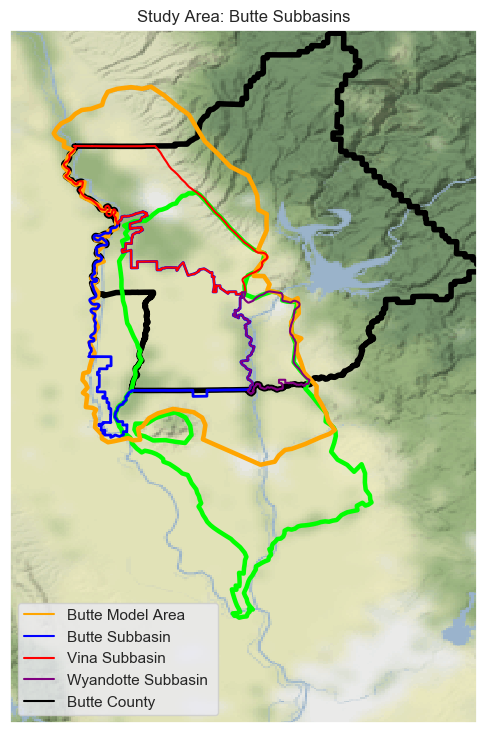

In [78]:


# Read datasets
flowlines = ShapelyFeature(Reader("../shape/streams.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 1.6)
butte_gwm = ShapelyFeature(Reader("../shape/butte_gw_model.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='orange', facecolor = 'none', linewidth = 3.25)

b_sub = ShapelyFeature(Reader("../shape/SGMA_Butte Subbasin_2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)

v_sub = ShapelyFeature(Reader("../shape/SGMA_Vina Subbasin_Bulletin 118-2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='red', facecolor = 'none', linewidth = 1.5)

w_sub = ShapelyFeature(Reader("../shape/SGMA_Wyandotte Subbasin_2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='purple', facecolor = 'none', linewidth = 1.5)
CA = ShapelyFeature(Reader("../shape/CA_State_TIGER2016.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 1.5)
#cv = ShapelyFeature(Reader("../shape/study_area/CV_boundary.shp").geometries(),
 #                       ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)
c2vsim_5 = ShapelyFeature(Reader("../shape/study_area/c2vsim_subregion5.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='lime', facecolor = 'none', linewidth = 3.25)
butte_co = ShapelyFeature(Reader("../shape/study_area/Butte_co_rpj.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 4)
#stream_gauges = ShapelyFeature(Reader("../shape/gauges_in_butte.shp").geometries(),
#                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)
                          
shapefile = "../shape/study_area/c2vsim_subregion5.shp"
#shapefile = "../shape/CA_State_TIGER2016.shp"
plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
'''
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.right_labels = False

gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
'''

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon-.25, urlon+.25, lllat-.25, urlat+.385])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add wells
#wells = list(cartopy.io.shapereader.Reader("../shape/casgem_wells.shp").geometries())
#ax.scatter([point.x for point in wells],
#           [point.y for point in wells],
#           transform=ccrs.PlateCarree(), color = 'orange', s = 4)

# Add shapefiles
#ax.add_feature(flowlines)
ax.add_feature(butte_co)
ax.add_feature(c2vsim_5)
#ax.add_feature(CA)
ax.add_feature(butte_gwm)
ax.add_feature(b_sub)
ax.add_feature(v_sub)
ax.add_feature(w_sub)
# Add reservoirs
#reservoirs = list(cartopy.io.shapereader.Reader("../shape/cdec_reservoirs.shp").geometries())
#ax.scatter([point.x for point in reservoirs],
#           [point.y for point in reservoirs],
#           transform=ccrs.PlateCarree(), color = 'purple', s = 150, zorder = 1000)

# Add gauges
#reservoirs = list(cartopy.io.shapereader.Reader("../shape/gauges_in_butte.shp").geometries())
#ax.scatter([point.x for point in reservoirs],
#           [point.y for point in reservoirs],
#           transform=ccrs.PlateCarree(), color = 'blue', s = 125, zorder = 1000)

#ax.scatter(prism_stations["Longitude"], prism_stations["Latitude"], color='black', s = 50, zorder = 1000)

#ax.scatter([-121.824430], [39.608639], color='red', s = 60, zorder = 1000) # CIMIS station 12
#ax.scatter([-121.8670], [39.5771], color='blue', s = 60, zorder = 1000) # Flux tower
#ax.scatter([-121.8374], [39.7284], color='orange', s=60, zorder = 1000) # CalWater wells
#ax.scatter(usgs_streams_lon, usgs_streams_lat, color='purple', s=60, zorder=1000)
#ax.scatter(cdec_streams_lon, cdec_streams_lat, color='yellow', s=60, zorder=1000)
# Setup legend
handles, labels = plt.gca().get_legend_handles_labels()

# Add legend entries
prism_line = Line2D(range(0), range(0), label = 'PRISM station', color="none", marker='o', markerfacecolor="black")
cimis_line = Line2D(range(0), range(0), label = 'CIMIS station 12', color="none", marker='o', markerfacecolor="red")

flux_line = Line2D(range(0), range(0), label = 'Flux Tower - US-RGB: Butte County Rice Farm', color="none", marker='o', markerfacecolor="blue")
calwater_line = Line2D(range(0), range(0), label = 'CalWater Wells', color="none", marker='o', markerfacecolor="orange")
usgs_line = Line2D(range(0), range(0), label = 'USGS Stream Gages', color="none", marker='o', markerfacecolor="purple")
cdec_line = Line2D(range(0), range(0), label = 'CDEC Stream Gages', color="none", marker='o', markerfacecolor="yellow")

#well_line = Line2D(range(0), range(0), label = 'Groundwater Wells', color="none", marker='o', markerfacecolor="orange")
#gauge_line = Line2D(range(0), range(0), label = 'Stream Gauges', color="none", marker='o', markerfacecolor="blue")
ksb_line = Line2D([0], [0], label='Butte Model Area', color='orange')
b_line = Line2D([0], [0], label='Butte Subbasin', color='blue')
v_line = Line2D([0], [0], label='Vina Subbasin', color='red')
w_line = Line2D([0], [0], label='Wyandotte Subbasin ', color='purple')
shed_line = Line2D([0], [0], label='C2VSim Region 5', color='lime')
co_line = Line2D([0], [0], label='Butte County', color='black')
#canals_line = Line2D([0], [0], label='Rivers, Canals, Aqueducts', color='blue', linewidth = 2)
# rivers_line = Line2D([0], [0], label='Rivers', color='blue', linewidth = 4)


# Plot legend 
#handles.extend([cimis_line, flux_line, calwater_line, usgs_line, cdec_line, ksb_line, b_line, v_line, w_line, co_line])
handles.extend([ksb_line, b_line, v_line, w_line, co_line])
ax.legend(handles=handles, loc = 'lower left').set_zorder(99999)

# Set the title
ax.set_title("Study Area: Butte Subbasins", size = 12)

# Fix aspect
ax.set_aspect('auto')

plt.show()


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


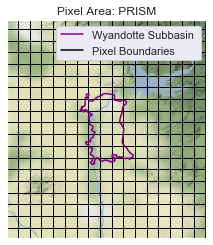

In [15]:


# Read datasets
flowlines = ShapelyFeature(Reader("../shape/streams.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 1.6)
butte_gwm = ShapelyFeature(Reader("../shape/butte_gw_model.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='orange', facecolor = 'none', linewidth = 3.25)

b_sub = ShapelyFeature(Reader("../shape/SGMA_Butte Subbasin_2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)

v_sub = ShapelyFeature(Reader("../shape/SGMA_Vina Subbasin_Bulletin 118-2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='red', facecolor = 'none', linewidth = 1.5)

w_sub = ShapelyFeature(Reader("../shape/SGMA_Wyandotte Subbasin_2018.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='purple', facecolor = 'none', linewidth = 1.5)

#cv = ShapelyFeature(Reader("../shape/CV_boundary.shp").geometries(),
#                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)
butte_co = ShapelyFeature(Reader("../shape/study_area/Butte_co_rpj.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='lime', facecolor = 'none', linewidth = 3.25)
#stream_gauges = ShapelyFeature(Reader("../shape/gauges_in_butte.shp").geometries(),
#                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)


# Setup the figure
shapefile = "../shape/SGMA_Wyandotte Subbasin_2018.shp"
#fig, axes = plt.figure(figsize = (14,9), projection=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels= False
#gl.right_labels = False

#gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
#gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 9, 'color': 'gray'}
#gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon-.25, urlon+.25, lllat-.25, urlat+.25])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

ax.add_feature(w_sub)
width= 0.04
height =0.04
for i in range(-20,15):
    for j in range(-20,15):
        ax.add_patch(mpatches.Rectangle(xy=[-121.20+i*width, 39.20+j*height], width=width, height=height,
                                    facecolor='none',
                                    edgecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree())
                         )
# Setup legend
handles, labels = plt.gca().get_legend_handles_labels()
w_line = Line2D([0], [0], label='Wyandotte Subbasin ', color='purple')
pixel_line = Line2D([0], [0], label='Pixel Boundaries', color='black')
#pixel_leg = mpatches.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5, label='PERSIANN-CDR pixel area')
# Plot legend 
handles.extend([w_line, pixel_line])
ax.legend(handles=handles, loc = 'upper right', framealpha=1).set_zorder(99999)

# Set the title
ax.set_title("Pixel Area: PRISM", size = 12)

# Fix aspect
ax.set_aspect('auto')

# Butte Water Budgets

In [16]:
b_sub_wb = pd.read_csv('../data/water_budget_spreadsheets/butte_wy_budget.csv', skiprows=3, parse_dates=['WY'], 
                      thousands=',')
b_sub_wb_rainfall = b_sub_wb['Precipitation']*1.23348e-6 # convert to km3
b_sub_wb_et = (b_sub_wb['Ag.1']+b_sub_wb['U&I.1']+b_sub_wb['Managed Wetlands.1']+b_sub_wb[
    'Native Veg']+b_sub_wb['Canal Evap'])*1.23348e-6

In [17]:
v_sub_wb = pd.read_csv('../data/water_budget_spreadsheets/vina_wy_budget.csv', skiprows=3, parse_dates=['WY'], 
                      thousands=',')
v_sub_wb_rainfall = v_sub_wb['Precipitation']*1.23348e-6 # convert to km3
v_sub_wb_et = (v_sub_wb['Ag.1']+v_sub_wb['U&I.1']+v_sub_wb['Managed Wetlands.1']+v_sub_wb[
    'Native Veg']+v_sub_wb['Canal Evap'])*1.23348e-6

In [18]:
w_sub_wb = pd.read_csv('../data/water_budget_spreadsheets/wyandotte_wy_budget.csv', skiprows=3, parse_dates=['WY'], 
                      thousands=',')
w_sub_wb_rainfall = w_sub_wb['Precipitation']*1.23348e-6 # convert to km3
w_sub_wb_et = (w_sub_wb['Ag.1']+w_sub_wb['U&I.1']+w_sub_wb['Managed Wetlands.1']+w_sub_wb[
    'Native Veg']+w_sub_wb['Canal Evap'])*1.23348e-6

# Precipitation Remote Sensing Data

In [19]:
# Load preprocessed RS Data (P, R, SM, SWE) generated with 02_P_ET_SM
def load_precip_analysis(fn):
    rsdf = rs.col_to_dt(pd.read_csv(fn))
    rs_prism = np.array(rsdf['p_prism'])
    rs_gpm = np.array(rsdf['p_gpm'])
    rs_dmet = np.array(rsdf['p_dmet'])
    rs_chirps = np.array(rsdf['p_chirps'])
    rs_psn = np.array(rsdf['p_psn'])
    rs_average = np.array((rs_prism+rs_gpm+rs_dmet+rs_chirps+rs_psn)/5)
    rsdf['average'] = rs_average
    rsdf['Date'] = rsdf.index
    rsdf['water_year'] = rsdf['Date'].dt.year.where(rsdf['Date'].dt.month < 10, rsdf['Date'].dt.year + 1)
    rs_average_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['average'].sum()
    rs_prism_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_prism'].sum()
    rs_daymet_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_dmet'].sum()
    rs_gpm_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_gpm'].sum()
    rs_chirps_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_chirps'].sum()
    rs_psn_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_psn'].sum()
    
    rsdf_yearly = pd.concat([rs_average_yearly, rs_prism_yearly, rs_daymet_yearly, rs_gpm_yearly,
                           rs_chirps_yearly, rs_psn_yearly], axis=1)
    return rsdf, rsdf_yearly

In [20]:
precip_butte, precip_butte_yearly = load_precip_analysis("../data/butte_rs_analysis_dat.csv")
precip_vina, precip_vina_yearly = load_precip_analysis("../data/vina_rs_analysis_dat.csv")
precip_wyandotte, precip_wyandotte_yearly = load_precip_analysis("../data/wyandotte_rs_analysis_dat.csv")

precip_butte_yearly = precip_butte_yearly[:-1]
precip_vina_yearly = precip_vina_yearly[:-1]
precip_wyandotte_yearly = precip_wyandotte_yearly[:-1]

b_sub_wb_precip_time = b_sub_wb['WY'][11:31]
b_sub_wb_precip = b_sub_wb_rainfall[11:31]

v_sub_wb_precip_time = v_sub_wb['WY'][11:31]
v_sub_wb_precip = v_sub_wb_rainfall[11:31]

w_sub_wb_precip_time = w_sub_wb['WY'][11:31]
w_sub_wb_precip = w_sub_wb_rainfall[11:31]

precip_butte_yearly.info()
print(b_sub_wb_precip_time)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 20 entries, 2001 to 2020
Freq: A-DEC
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   average   20 non-null     float64
 1   p_prism   20 non-null     float64
 2   p_dmet    20 non-null     float64
 3   p_gpm     20 non-null     float64
 4   p_chirps  20 non-null     float64
 5   p_psn     20 non-null     float64
dtypes: float64(6)
memory usage: 1.1 KB
11   2001-01-01
12   2002-01-01
13   2003-01-01
14   2004-01-01
15   2005-01-01
16   2006-01-01
17   2007-01-01
18   2008-01-01
19   2009-01-01
20   2010-01-01
21   2011-01-01
22   2012-01-01
23   2013-01-01
24   2014-01-01
25   2015-01-01
26   2016-01-01
27   2017-01-01
28   2018-01-01
29   2019-01-01
30   2020-01-01
Name: WY, dtype: datetime64[ns]


In [21]:
print(sns.color_palette())

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


In [22]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

# Comparing Aakash vs. Butte

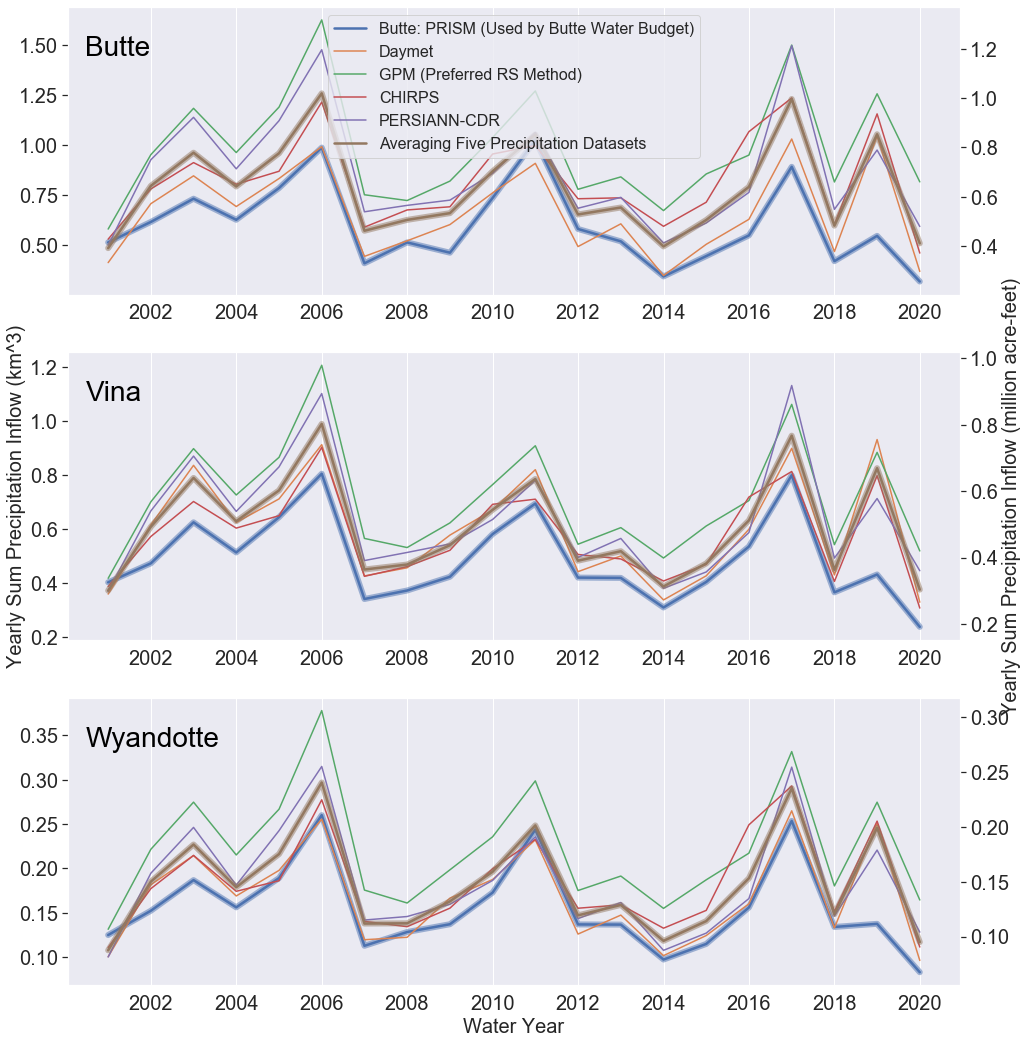

In [23]:
#sns.set_style('whitegrid')
#sns.reset_orig()
sns.set()
fig, axes = plt.subplots(3, 1, figsize=(16,18))
axes[0].plot(b_sub_wb_precip_time, b_sub_wb_precip, linewidth=2.5, 
             label='Butte: PRISM (Used by Butte Water Budget)')
axes[0].plot(b_sub_wb_precip_time, b_sub_wb_precip,
             color=sns.color_palette()[0], linewidth=6, alpha=0.5)
axes[0].plot(precip_butte_yearly.index.to_timestamp(), precip_butte_yearly['p_dmet'], 
             label='Daymet')
axes[0].plot(precip_butte_yearly.index.to_timestamp(), precip_butte_yearly['p_gpm'], 
             label='GPM (Preferred RS Method)')
axes[0].plot(precip_butte_yearly.index.to_timestamp(), precip_butte_yearly['p_chirps'], 
             label='CHIRPS')
axes[0].plot(precip_butte_yearly.index.to_timestamp(), precip_butte_yearly['p_psn'], 
             label='PERSIANN-CDR')
axes[0].plot(precip_butte_yearly.index.to_timestamp(), precip_butte_yearly['average'], linewidth=2.5,
             label='Averaging Five Precipitation Datasets')
axes[0].plot(precip_butte_yearly.index.to_timestamp(), precip_butte_yearly['average'],
             color=sns.color_palette()[5], linewidth=6, alpha=0.5)
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].text(0.02, 0.9, 'Butte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[0].transAxes,
        color='black', fontsize=28)
axes_0_twin = axes[0].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[0].get_ylim()
# apply function and set transformed values to right axis limits
axes_0_twin.set_ylim((af(ymin),af(ymax)))
axes_0_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_0_twin.plot([],[])
axes[0].set_zorder(axes_0_twin.get_zorder()+1)
axes[0].yaxis.grid(False)
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
#axes[0].set_xlabel('Water Year', fontsize=14)
#axes[0].set_ylabel('Yearly Sum AET Outflow (km^3)', fonts
#axes[0].set_xlabel('Water Year', fontsize=14)
#axes[0].set_ylabel('Yearly Sum Precipitation Inflow (km^3)', fontsize=14)
axes[0].legend(fontsize=16)
#axes[0].set_ylim([0,1.7])
axes[1].plot(v_sub_wb_precip_time, v_sub_wb_precip, linewidth=2.5,
             label='Vina: PRISM (Used by Butte Water Budget)')
axes[1].plot(v_sub_wb_precip_time, v_sub_wb_precip, 
             color=sns.color_palette()[0], linewidth=6, alpha=0.5)
axes[1].plot(precip_vina_yearly.index.to_timestamp(), precip_vina_yearly['p_dmet'], 
             label='Vina: Daymet')
axes[1].plot(precip_vina_yearly.index.to_timestamp(), precip_vina_yearly['p_gpm'], 
             label='Vina: GPM (Preferred RS Method)')
axes[1].plot(precip_vina_yearly.index.to_timestamp(), precip_vina_yearly['p_chirps'], 
             label='Vina: CHIRPS')
axes[1].plot(precip_vina_yearly.index.to_timestamp(), precip_vina_yearly['p_psn'], 
             label='Vina: PERSIANN-CDR')
axes[1].plot(precip_vina_yearly.index.to_timestamp(), precip_vina_yearly['average'], linewidth=2.5,
             label='Vina: Averaging Five Precipitation Datasets')
axes[1].plot(precip_vina_yearly.index.to_timestamp(), precip_vina_yearly['average'],
             color=sns.color_palette()[5],linewidth=6, alpha=0.5)
#axes[1].grid()
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
#axes[1].set_xlabel('Water Year', fontsize=20)
axes[1].set_ylabel('Yearly Sum Precipitation Inflow (km^3)', fontsize=20)
axes[1].text(0.02, 0.9, 'Vina',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[1].transAxes,
        color='black', fontsize=28)
axes_1_twin = axes[1].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[1].get_ylim()
# apply function and set transformed values to right axis limits
axes_1_twin.set_ylim((af(ymin),af(ymax)))
axes_1_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_1_twin.plot([],[])
axes[1].set_zorder(axes_1_twin.get_zorder()+1)
axes[1].yaxis.grid(False)
axes_1_twin.set_ylabel('Yearly Sum Precipitation Inflow (million acre-feet)', fontsize=20)
#axes[1].set_ylim([0,1.7])
axes[2].plot(w_sub_wb_precip_time, w_sub_wb_precip, linewidth=2.5,
             label='Wyandotte: PRISM (Used by Butte Water Budget)')
axes[2].plot(w_sub_wb_precip_time, w_sub_wb_precip,
             color=sns.color_palette()[0], linewidth=6, alpha=0.5)
axes[2].plot(precip_wyandotte_yearly.index.to_timestamp(), precip_wyandotte_yearly['p_dmet'], 
             label='Wyandotte: Daymet')
axes[2].plot(precip_wyandotte_yearly.index.to_timestamp(), precip_wyandotte_yearly['p_gpm'], 
             label='Wyandotte: GPM (Preferred RS Method)')
axes[2].plot(precip_wyandotte_yearly.index.to_timestamp(), precip_wyandotte_yearly['p_chirps'], 
             label='Wyandotte: CHIRPS')
axes[2].plot(precip_wyandotte_yearly.index.to_timestamp(), precip_wyandotte_yearly['p_psn'], 
             label='Wyandotte: PERSIANN-CDR')
axes[2].plot(precip_wyandotte_yearly.index.to_timestamp(), precip_wyandotte_yearly['average'], linewidth=2.5,
             label='Wyandotte: Averaging Five Precipitation Datasets')
axes[2].plot(precip_wyandotte_yearly.index.to_timestamp(), precip_wyandotte_yearly['average'], 
             color=sns.color_palette()[5],linewidth=6, alpha=0.5)
#axes[2].grid()
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel('Water Year', fontsize=20)
axes[2].text(0.02, 0.9, 'Wyandotte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[2].transAxes,
        color='black', fontsize=28)
axes_2_twin = axes[2].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[2].get_ylim()
# apply function and set transformed values to right axis limits
axes_2_twin.set_ylim((af(ymin),af(ymax)))
axes_2_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_2_twin.plot([],[])
axes[2].set_zorder(axes_2_twin.get_zorder()+1)
axes[2].yaxis.grid(False)
#axes[2].set_ylabel('Yearly Sum Precipitation Inflow (km^3)', fontsize=20)
#axes[1].set_ylim([0,1.7])
#axes[2].legend(fontsize=14)

In [24]:
precip_butte_yearly

average   p_prism    p_dmet     p_gpm  p_chirps     p_psn
water_year                                                            
2001        0.482482  0.400267  0.410023  0.577906  0.527405  0.496810
2002        0.793843  0.611327  0.704842  0.950089  0.778370  0.924588
2003        0.959829  0.726206  0.844093  1.181764  0.910320  1.136761
2004        0.790810  0.621351  0.690584  0.960646  0.802155  0.879315
2005        0.957110  0.779941  0.830696  1.187952  0.867078  1.119882
2006        1.256726  0.981740  0.990028  1.624088  1.212956  1.474820
2007        0.569471  0.404834  0.441231  0.749503  0.587491  0.664296
2008        0.623771  0.509131  0.519244  0.720628  0.673490  0.696363
2009        0.657506  0.457602  0.600252  0.817790  0.689301  0.722583
2010        0.866707  0.729413  0.758880  1.035653  0.953289  0.856298
2011        1.050465  1.020235  0.906618  1.268687  0.995552  1.061235
2012        0.650880  0.575672  0.490303  0.776813  0.729530  0.682084
2013        0.685758  0.515183  0.604066  0.838832  0.734183  0.736527
2014        0.491050  0.339135  0.345428  0.670351  0.591688  0.508645
2015        0.623162  0.440708  0.501617  0.853413  0.712072  0.607999
2016        0.788864  0.543675  0.626586  0.947880  1.064957  0.761224
2017        1.228518  0.887147  1.028290  1.498168  1.233653  1.495330
2018        0.594937  0.419470  0.465061  0.813471  0.600140  0.676544
2019        1.052145  0.835690  1.043514  1.254412  1.153991  0.973122
2020        0.506544  0.304351  0.365932  0.813992  0.457770  0.590676

In [25]:
butte_precip = np.array(b_sub_wb_precip)
average_precip = np.array(precip_butte_yearly['average'])
print("Butte Average vs. Butte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((average_precip-butte_precip)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((average_precip-butte_precip)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((average_precip-butte_precip)/butte_precip)*100))
print("")


vina_precip = np.array(v_sub_wb_precip)
average_precip = np.array(precip_vina_yearly['average'])
print("Vina Average vs. Vina:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((average_precip-vina_precip)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((average_precip-vina_precip)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((average_precip-vina_precip)/vina_precip)*100))
print("")


wyandotte_precip = np.array(w_sub_wb_precip)
average_precip = np.array(precip_wyandotte_yearly['average'])
print("Wyandotte Average vs. Wyandotte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((average_precip-wyandotte_precip)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((average_precip-wyandotte_precip)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((average_precip-wyandotte_precip)/wyandotte_precip)*100))
print("")


Butte Average vs. Butte:
Average difference in time series in million acre-feet
0.17238090221531624
Average difference in time series in km^3
0.21262850057519206
Average precent difference in time series
33.91989555277966

Vina Average vs. Vina:
Average difference in time series in million acre-feet
0.11360644842479417
Average difference in time series in km^3
0.14013135140727084
Average precent difference in time series
26.447112990968964

Wyandotte Average vs. Wyandotte:
Average difference in time series in million acre-feet
0.028472932227543372
Average difference in time series in km^3
0.0351208098386649
Average precent difference in time series
19.83269879280909



# AET Comparison

In [26]:
old_openet = rs.col_to_dt(pd.read_csv("../data/openet_butte_subbasin_ee.csv"))
#new_openet = rs.col_to_dt(pd.read_csv("../data/et_images/et_images_butte/butte_openet_timeseries.csv"))
#new_openet = new_openet * 1e-6 *area_bs_km2

In [27]:
old_openet

spatial_ref  et_ensemble_mad  et_ensemble_mad_min  \
time                                                            
2016-01-01            0         0.024612             0.015946   
2016-02-01            0         0.052069             0.031957   
2016-03-01            0         0.066838             0.041595   
2016-04-01            0         0.094634             0.071169   
2016-05-01            0         0.131616             0.101642   
...                 ...              ...                  ...   
2021-07-01            0         0.169755             0.141375   
2021-08-01            0         0.144865             0.117883   
2021-09-01            0         0.094045             0.076397   
2021-10-01            0         0.043142             0.030847   
2021-11-01            0         0.030272             0.020466   

            et_ensemble_mad_max  
time                             
2016-01-01             0.033481  
2016-02-01             0.072173  
2016-03-01             0.091942  
2016-04-01             0.116987  
2016-05-01             0.161250  
...                         ...  
2021-07-01             0.198259  
2021-08-01             0.171625  
2021-09-01             0.113405  
2021-10-01             0.055441  
2021-11-01             0.039908  

[66 rows x 4 columns]

In [28]:
new_openet

NameError: name 'new_openet' is not defined

In [29]:
# Load preprocessed RS Data (P, R, SM, SWE) generated with 02_P_ET_SM
def load_et_analysis(fn, sse, modkc, openet, region):
    rsdf = rs.col_to_dt(pd.read_csv(fn))
    rs_modis = np.array(rsdf['aet_modis'])
    rs_pet_modis = np.array(rsdf['pet_modis'])
    rs_gldas = np.array(rsdf['aet_gldas'])
    rs_tc = np.array(rsdf['aet_tc'])
    rs_fldas = np.array(rsdf['aet_fldas'])
    rs_sse = rs.col_to_dt(pd.read_csv(sse))
    average = np.array(rs_modis[:-3].flatten()+rs_gldas[:-3].flatten()+rs_tc[:-3].flatten()
               +rs_fldas[:-3].flatten()+np.array(rs_sse[13:]).flatten()/5)
    rs_average = pd.DataFrame(average, columns=['average'])
    rs_modkc = rs.col_to_dt(pd.read_csv(modkc))
    if region=='Butte':
        rs_openet = rs.col_to_dt(pd.read_csv(openet))*1e-6*area_bs_km2
    elif region=='Vina':
        rs_openet = rs.col_to_dt(pd.read_csv(openet))*1e-6*area_vs_km2
    elif region=='Wyandotte':
        rs_openet = rs.col_to_dt(pd.read_csv(openet))*1e-6*area_ws_km2
    rsdf['Date'] = rsdf.index
    rs_average['Date'] = rsdf.index[:-3]
    rs_sse['Date'] = rs_sse.index
    rs_modkc['Date'] = rs_modkc.index
    rs_openet['Date'] = rs_openet.index
    
    rsdf['water_year'] = rsdf['Date'].dt.year.where(rsdf['Date'].dt.month < 10, rsdf['Date'].dt.year + 1)
    rs_average['water_year'] = rs_average['Date'].dt.year.where(
        rs_average['Date'].dt.month < 10, rs_average['Date'].dt.year + 1)
    rs_sse['water_year'] = rs_sse['Date'].dt.year.where(rs_sse['Date'].dt.month < 10, rs_sse['Date'].dt.year + 1)
    rs_modkc['water_year'] = rs_modkc['Date'].dt.year.where(rs_modkc['Date'].dt.month < 10, rs_modkc['Date'].dt.year + 1)
    rs_openet['water_year'] = rs_openet['Date'].dt.year.where(rs_openet['Date'].dt.month < 10, rs_openet['Date'].dt.year + 1)
    #rs_average_yearly = rs_average.groupby(pd.PeriodIndex(rs_average['water_year'], freq="Y"))['average'].sum()
    rs_sse_yearly = rs_sse.groupby(pd.PeriodIndex(rs_sse['water_year'], freq="Y"))['ssebop'].sum()[1:]
    rs_modkc_yearly = rs_modkc.groupby(pd.PeriodIndex(rs_modkc['water_year'], freq="Y"))['MODkc'].sum()

    try:
        rs_openet_yearly = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['openet'].sum()
    except:
        rs_openet_yearly = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['et_ensemble_mad'].sum()
    rs_openet_yearly_max = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['et_ensemble_mad_max'].sum()
    rs_openet_yearly_min = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['et_ensemble_mad_min'].sum()
    rs_openet_disalexi = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['DisALEXI_ET'].sum()
    rs_openet_ptjpl = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['PT-JPL_ET'].sum()
    rs_openet_sims = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['SIMS_ET'].sum()
    rs_openet_ssebop = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['SSEBop_ET'].sum()
    rs_openet_eemetric = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['eeMETRIC_ET'].sum()
    rs_openet_geesebal = rs_openet.groupby(pd.PeriodIndex(rs_openet['water_year'], freq="Y"))['geeSEBAL_ET'].sum()
    
    
    rs_preferred_yearly = pd.Series((rs_sse_yearly + rs_modkc_yearly) / 2, name='preferred')
    rs_modis_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['aet_modis'].sum()
    rs_modis_pet_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq='Y'))['pet_modis'].sum()
    rs_gldas_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['aet_gldas'].sum()
    rs_fldas_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['aet_fldas'].sum()
    rs_tc_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['aet_tc'].sum()
    rs_average_yearly = pd.DataFrame((rs_sse_yearly+rs_modis_yearly+rs_gldas_yearly+rs_fldas_yearly+rs_tc_yearly+rs_modkc_yearly)/6, 
    columns=['average'])
    rs_preferred_yearly = pd.DataFrame((rs_modkc_yearly+rs_sse_yearly)/2, columns=['preferred'])
    rsdf_yearly = pd.concat([rs_average_yearly, rs_sse_yearly, rs_modis_pet_yearly,rs_modkc_yearly,
                             rs_modis_yearly, rs_gldas_yearly, rs_fldas_yearly, rs_tc_yearly, rs_preferred_yearly,
                             rs_openet_yearly, rs_openet_yearly_min, rs_openet_yearly_max,
                            rs_openet_disalexi, rs_openet_ptjpl, rs_openet_sims, rs_openet_ssebop,
                            rs_openet_eemetric, rs_openet_geesebal], axis=1)

    return rsdf, rs_pet_modis, rsdf_yearly, rs_sse, rs_modkc, rs_openet

In [30]:
aet_butte, pet_modis_butte, aet_butte_yearly, aet_butte_ssebop, aet_butte_modkc, aet_butte_openet = load_et_analysis(
    "../data/butte_rs_analysis_dat.csv", 
    '../data/butte_ssebop_et.csv',
    "../data/butte_MODkc.csv",
    #"../data/openet_butte_subbasin.csv")
    #"../data/rs_analysis_dat_butte_openet.csv")
    "../data/et_images/et_images_butte/butte_openet_timeseries.csv",
    "Butte")
aet_vina, pet_modis_vina, aet_vina_yearly, aet_vina_ssebop, aet_vina_modkc, aet_vina_openet = load_et_analysis(
    "../data/vina_rs_analysis_dat.csv",
    "../data/vina_ssebop_et.csv",
    "../data/vina_MODkc.csv",
    #"../data/openet_vina_subbasin.csv")
    #"../data/rs_analysis_dat_vina_openet.csv")
    "../data/et_images/et_images_vina/vina_openet_timeseries.csv",
    "Vina")
aet_wyandotte, pet_modis_wyandotte, aet_wyandotte_yearly, aet_wyandotte_ssebop, aet_wyandotte_modkc, aet_wyandotte_openet = load_et_analysis(
    "../data/wyandotte_rs_analysis_dat.csv",
    "../data/wyandotte_ssebop_et.csv",
    "../data/wyandotte_MODkc.csv",
    #"../data/openet_wyandotte_subbasin.csv")
    #"../data/rs_analysis_dat_wyandotte_openet.csv")
    "../data/et_images/et_images_wyandotte/wyandotte_openet_timeseries.csv",
    "Wyandotte")
#aet_butte_yearly = aet_butte_yearly[1:-2]
#aet_vina_yearly = aet_vina_yearly[1:-2]
#aet_wyandotte_yearly = aet_wyandotte_yearly[1:-2]
aet_butte_yearly = aet_butte_yearly.loc[pd.Period('2002'): pd.Period('2020')]
aet_vina_yearly = aet_vina_yearly.loc[pd.Period('2002'): pd.Period('2020')]
aet_wyandotte_yearly = aet_wyandotte_yearly.loc[pd.Period('2002'): pd.Period('2020')]

monthly_start = '2016-01-01'
monthly_end = '2020-12-31'
aet_butte = aet_butte.loc[monthly_start:monthly_end]
aet_butte_ssebop = aet_butte_ssebop.loc[monthly_start:monthly_end]
aet_butte_modkc = aet_butte_modkc.loc[monthly_start:monthly_end]
aet_butte_openet = aet_butte_openet.loc[monthly_start:monthly_end]

aet_vina = aet_vina.loc[monthly_start:monthly_end]
aet_vina_ssebop = aet_vina_ssebop.loc[monthly_start:monthly_end]
aet_vina_modkc = aet_vina_modkc.loc[monthly_start:monthly_end]
aet_vina_openet = aet_vina_openet.loc[monthly_start:monthly_end]

aet_wyandotte = aet_wyandotte.loc[monthly_start:monthly_end]
aet_wyandotte_ssebop = aet_wyandotte_ssebop.loc[monthly_start:monthly_end]
aet_wyandotte_modkc = aet_wyandotte_modkc.loc[monthly_start:monthly_end]
aet_wyandotte_openet = aet_wyandotte_openet.loc[monthly_start:monthly_end]

b_sub_wb_aet_time = b_sub_wb['WY'][12:31]
b_sub_wb_aet = b_sub_wb_et[12:31]

v_sub_wb_aet_time = v_sub_wb['WY'][11:31]
v_sub_wb_aet = v_sub_wb_et[12:31]

w_sub_wb_aet_time = w_sub_wb['WY'][11:31]
w_sub_wb_aet = w_sub_wb_et[12:31]

In [31]:
aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'MODkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop': "SSEBop",
                'aet_modis': "MOD16"}

aetcoldict = {'aet_gldas':'aet_gldas', 
                'aet_fldas':'aet_fldas',  
                'aet_tc':'aet_tc',
                'aet_modis': "aet_modis"}

In [32]:
aet_butte.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2016-01-31 to 2020-12-31
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   p_prism     60 non-null     float64       
 1   p_gpm       60 non-null     float64       
 2   p_dmet      60 non-null     float64       
 3   p_chirps    60 non-null     float64       
 4   p_psn       60 non-null     float64       
 5   aet_modis   60 non-null     float64       
 6   aet_gldas   60 non-null     float64       
 7   aet_tc      60 non-null     float64       
 8   aet_fldas   60 non-null     float64       
 9   pet_modis   60 non-null     float64       
 10  pet_gldas   60 non-null     float64       
 11  pet_tc      60 non-null     float64       
 12  pet_nldas   60 non-null     float64       
 13  pet_gmet    60 non-null     float64       
 14  sm_smos     60 non-null     float64       
 15  sm_smap     48 non-null     float64       
 16  sm_tc   

In [33]:
flux_tower = pd.read_csv('../data/Butte_PET/Butte_Flux_Tower.csv', 
                         skiprows=2, parse_dates=['TIMESTAMP_START', 'TIMESTAMP_END'], na_values=-9999.0)

In [34]:
flux_tower['vaporization'] = (2.501 - 0.00237*flux_tower['TA_1_1_1'])*10e6
flux_tower['ET'] = flux_tower['LE_1_1_1'] / flux_tower['vaporization']*2.5

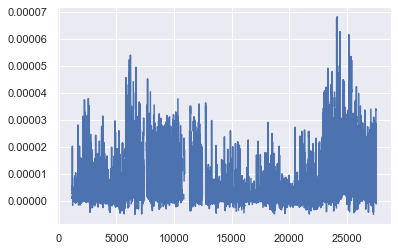

In [35]:
flux_tower['ET'].plot()

In [36]:
flux_tower['year_month'] = pd.to_datetime(flux_tower['TIMESTAMP_START']).dt.to_period('M')
flux_tower['year'] = pd.to_datetime(flux_tower['TIMESTAMP_START']).dt.to_period('Y')

In [37]:
flux_tower_monthly_mean = flux_tower.groupby('year_month').mean()*1e-6*area_bs_km2*86400*30*2.5

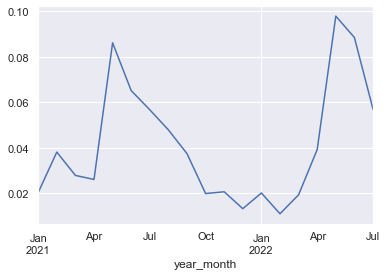

In [38]:
flux_tower_monthly_mean['ET'].plot()

In [39]:
flux_tower_yearly_sum = flux_tower_monthly_mean['ET'][0:12].sum()

In [40]:
area_bs_km2

1078.1677677876744

In [41]:
flux_tower_yearly_sum

0.45981613408775723

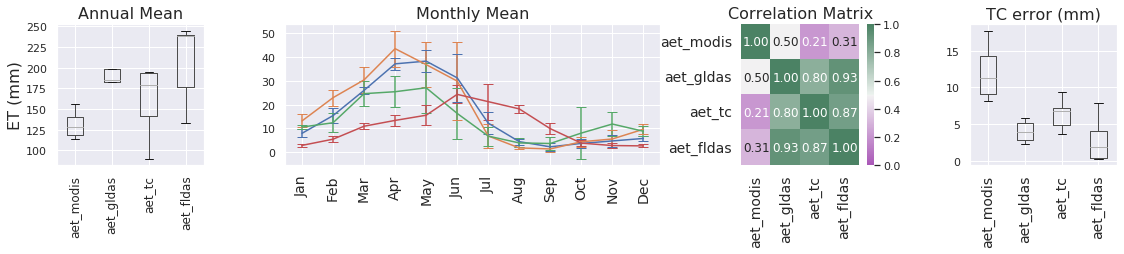

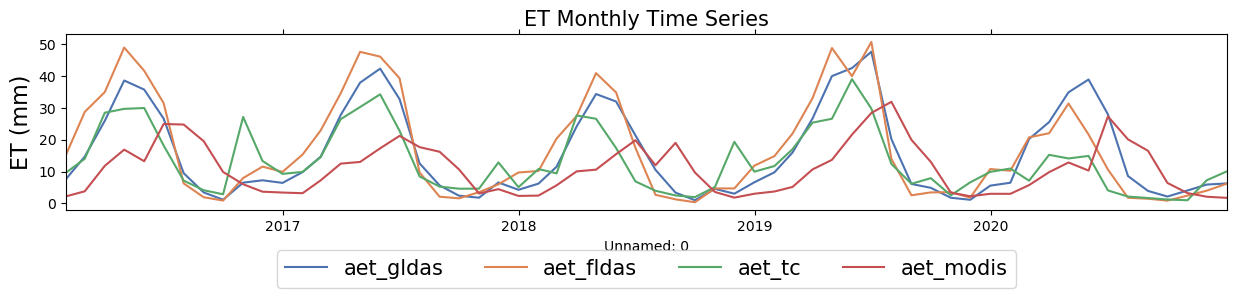

In [42]:
aet_butte_temp = aet_butte[['aet_modis', 'aet_gldas', 'aet_tc', 'aet_fldas']].copy()
[et1, et2, et3, et4, et5] = make_plots(aet_butte_temp/ area_km2 * 1e6, aetcoldict, var = "ET")

In [43]:
sns.set()

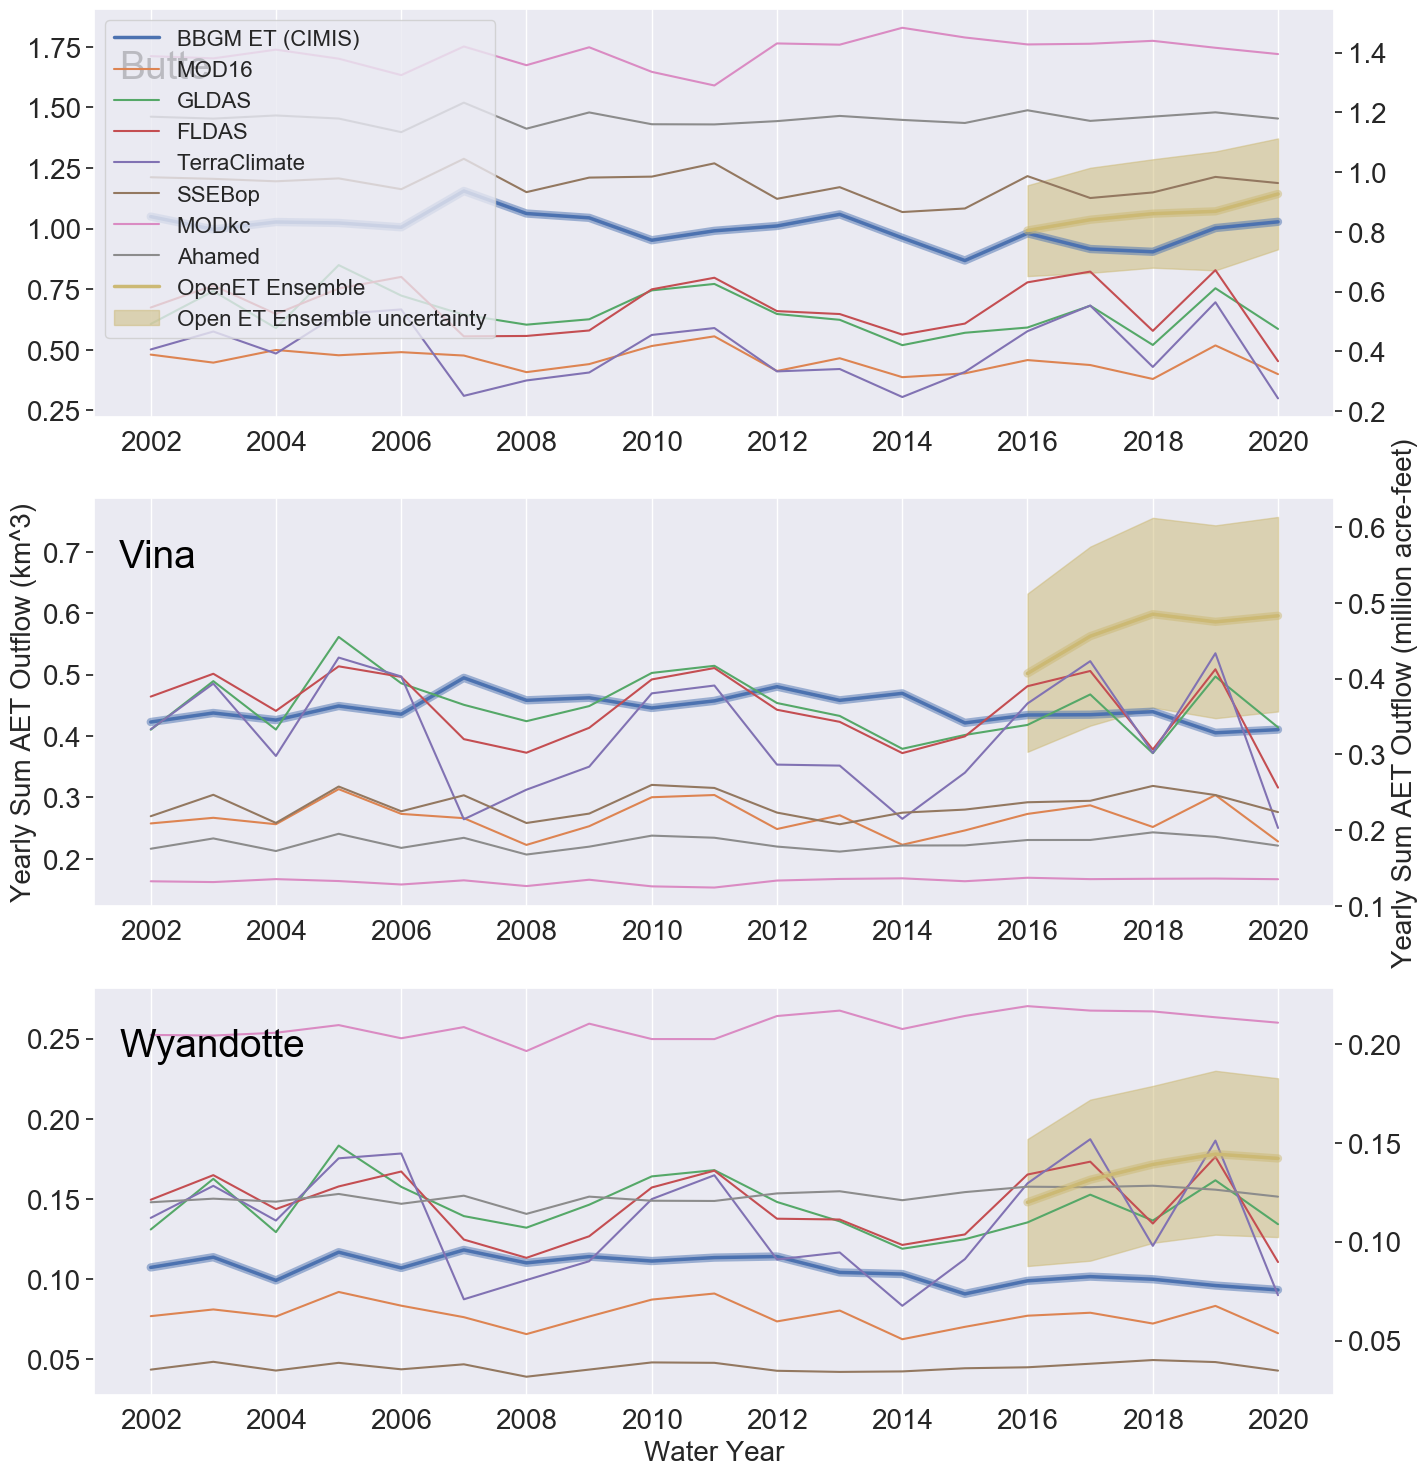

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

# get left axis limits
axes[0].plot(b_sub_wb_aet_time, b_sub_wb_aet, label='BBGM ET (CIMIS)', linewidth=2.5)
axes[0].plot(b_sub_wb_aet_time, b_sub_wb_aet,
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_modis'], 
             label='MOD16')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_gldas'], 
             label='GLDAS')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_fldas'], 
             label='FLDAS')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_tc'], 
             label='TerraClimate')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['ssebop'], 
             label='SSEBop')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['MODkc'], 
             label='MODkc')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['preferred'], 
             label='Ahamed')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad'], linewidth=2.5,
             label='OpenET Ensemble')
axes[0].fill_between(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad_min'],
                     aet_butte_yearly['et_ensemble_mad_max'], color=sns.color_palette()[8], alpha=0.5,
                    label='Open ET Ensemble uncertainty')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad'], 
        color=sns.color_palette()[8],linewidth=6, alpha=0.5)
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[0].text(0.02, 0.9, 'Butte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[0].transAxes,
        color='black', fontsize=28)
axes_0_twin = axes[0].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[0].get_ylim()
# apply function and set transformed values to right axis limits
axes_0_twin.set_ylim((af(ymin),af(ymax)))
axes_0_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_0_twin.plot([],[])
axes[0].set_zorder(axes_0_twin.get_zorder()+1)
axes[0].yaxis.grid(False)
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
#axes[0].set_xlabel('Water Year', fontsize=14)
#axes[0].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)
axes[0].legend(fontsize=16)
#axes[0].set_ylim([0,1.7])
axes[1].plot(v_sub_wb['WY'][12:31], v_sub_wb_et[12:31], label='Vina: BBGM ET (CIMIS)', linewidth=2.5)
axes[1].plot(v_sub_wb['WY'][12:31], v_sub_wb_et[12:31],
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_modis'], 
             label='Vina: MOD16')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_gldas'], 
             label='Vina: GLDAS')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_fldas'], 
             label='Vina: FLDAS')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_tc'], 
             label='Vina: TerraClimate')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['ssebop'], 
             label='Vina: SSEBop')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['MODkc'], 
             label='Vina: MODkc')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['preferred'], 
             label='Vina: Average of MODkc and SSEBop')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad'], linewidth=2.5,
             label='Vina: OpenET Ensemble')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad'], 
        color=sns.color_palette()[8],linewidth=6, alpha=0.5)
axes[1].fill_between(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad_min'],
                     aet_vina_yearly['et_ensemble_mad_max'], color=sns.color_palette()[8], alpha=0.5)
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[1].text(0.02, 0.9, 'Vina',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[1].transAxes,
        color='black', fontsize=28)
        
axes_1_twin = axes[1].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[1].get_ylim()
# apply function and set transformed values to right axis limits
axes_1_twin.set_ylim((af(ymin),af(ymax)))
axes_1_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_1_twin.plot([],[])
axes_1_twin.set_ylabel('Yearly Sum AET Outflow (million acre-feet)', fontsize=20)
axes[1].set_zorder(axes_1_twin.get_zorder()+1)
axes[1].yaxis.grid(False)
             
#axes[1].grid()
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
#axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=20)
#axes[1].set_ylim([0,1.7])
#axes[1].legend(fontsize=14, loc='upper left')
axes[2].plot(w_sub_wb['WY'][12:31], w_sub_wb_et[12:31], label='Wyandotte: BBGM ET (CIMIS)', linewidth=2.5)
axes[2].plot(w_sub_wb['WY'][12:31], w_sub_wb_et[12:31],
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_modis'], 
             label='Wyandotte: MOD16')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_gldas'], 
             label='Wyandotte: GLDAS')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_fldas'], 
             label='Wyandotte: FLDAS')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_tc'], 
             label='Wyandotte: TerraClimate')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['ssebop'], 
             label='Wyandotte: SSEBop')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['MODkc'], 
             label='Wyandotte: MODkc')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['preferred'], 
             label='Wyandotte: Average of MODkc and SSEBop')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad'], linewidth=2.5,
             label='Wyandotte: OpenET Ensemble')
axes[2].fill_between(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad_max'],
                     aet_wyandotte_yearly['et_ensemble_mad_min'], color=sns.color_palette()[8], alpha=0.5,
                    label='Open ET Ensemble uncertainty')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad'], 
        color=sns.color_palette()[8],linewidth=6, alpha=0.5)
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[2].text(0.02, 0.9, 'Wyandotte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[2].transAxes,
        color='black', fontsize=28)
#axes[2].grid()
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel('Water Year', fontsize=20)
#axes[2].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)

#axes[1].set_ylim([0,1.7])
#axes[2].legend(fontsize=14, loc = 'upper left')

axes_2_twin = axes[2].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[2].get_ylim()
# apply function and set transformed values to right axis limits
axes_2_twin.set_ylim((af(ymin),af(ymax)))
axes_2_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_2_twin.plot([],[])
axes[2].set_zorder(axes_2_twin.get_zorder()+1)
axes[2].yaxis.grid(False)

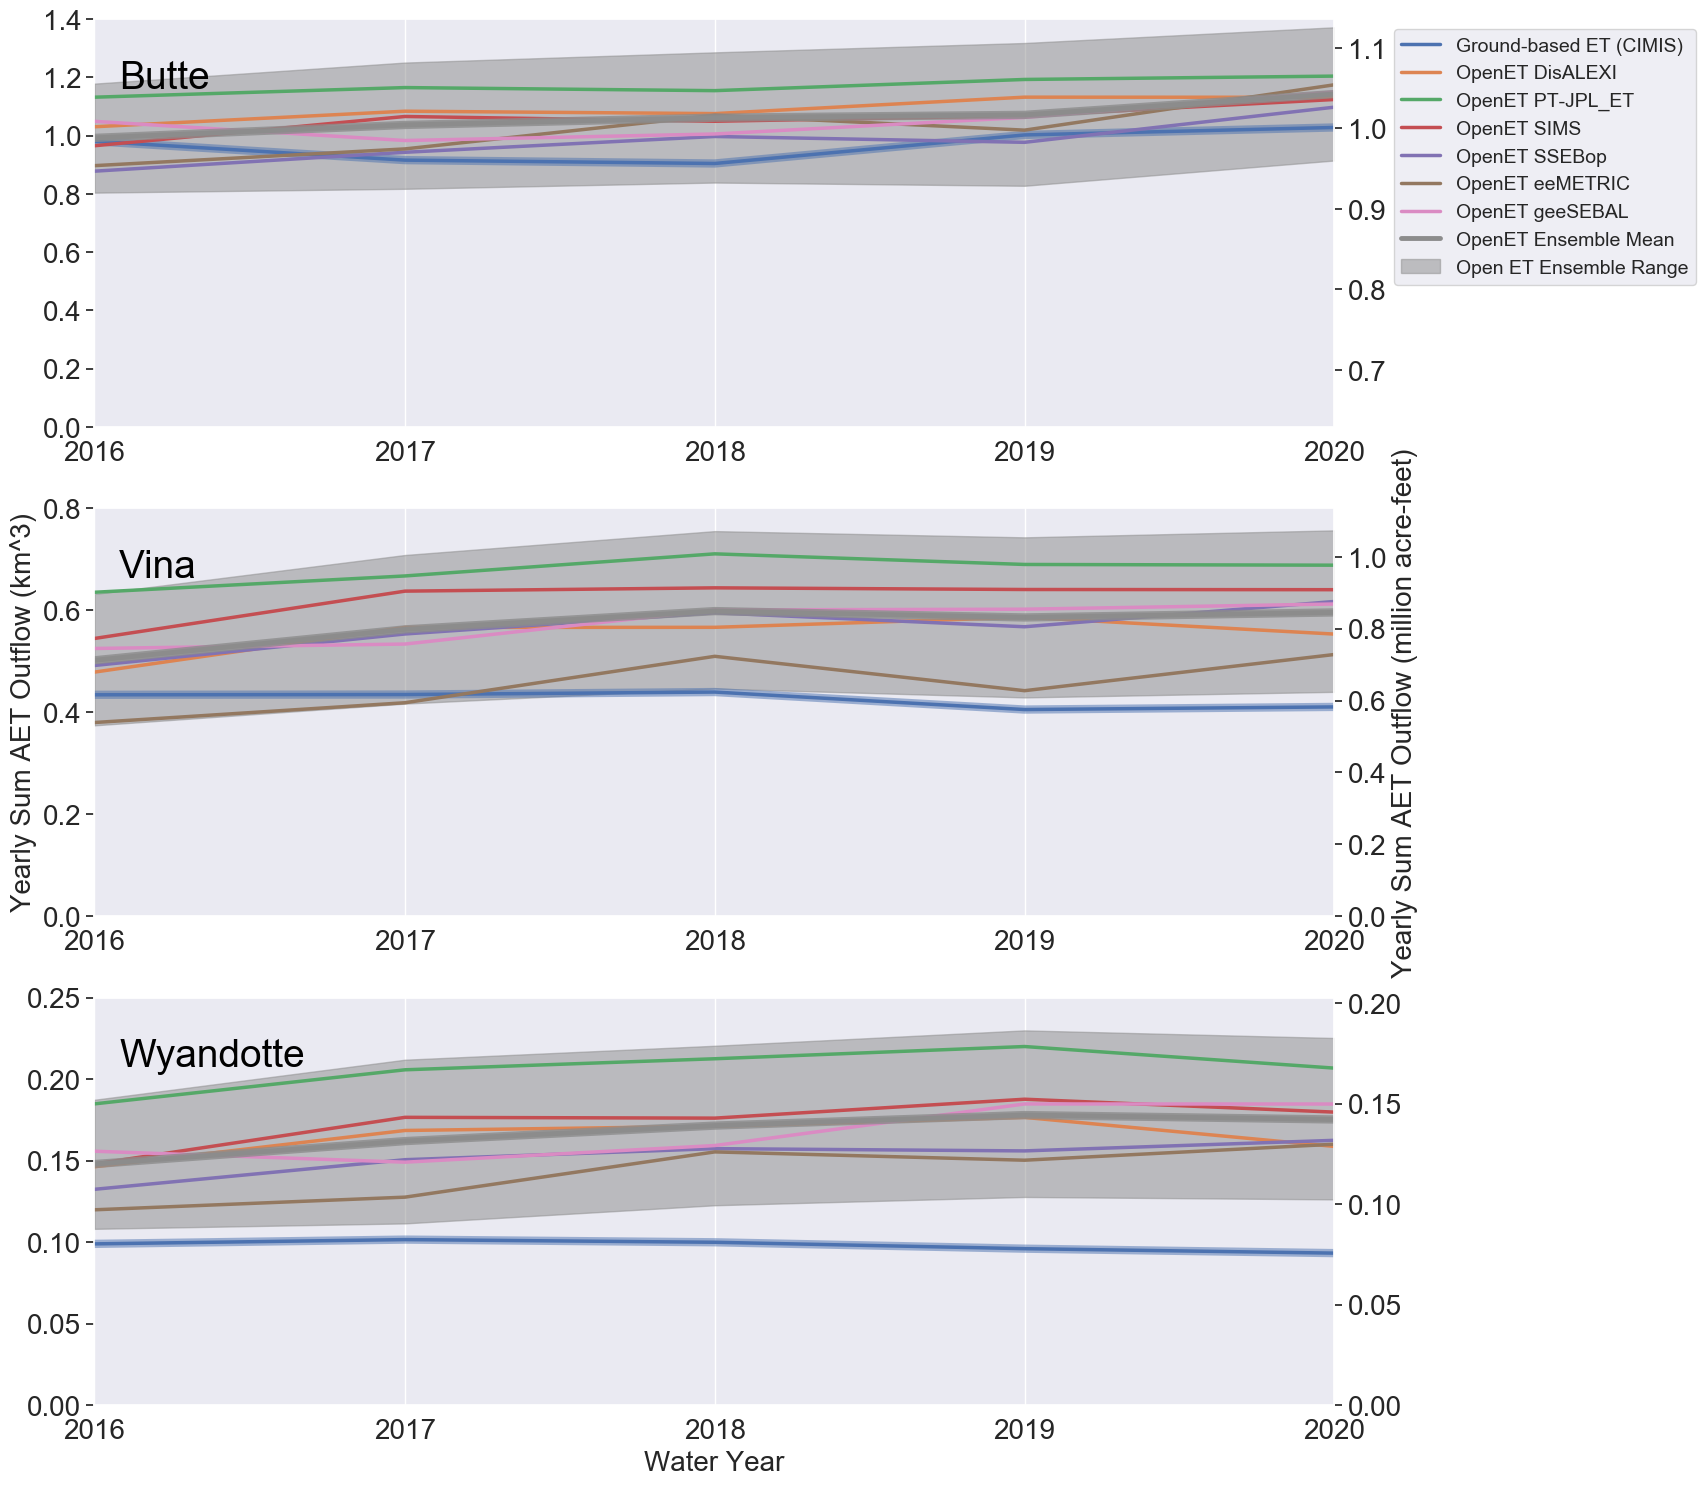

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

# get left axis limits
axes[0].plot(b_sub_wb_aet_time, b_sub_wb_aet, label='Ground-based ET (CIMIS)', linewidth=2.5)
axes[0].plot(b_sub_wb_aet_time, b_sub_wb_aet,
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['ssebop'], 
#             label='SSEBop')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['MODkc'], 
#             label='MODkc')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['preferred'], 
#             label='Ahamed')


axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['DisALEXI_ET'], linewidth=2.5,
             label='OpenET DisALEXI')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['PT-JPL_ET'], linewidth=2.5,
             label='OpenET PT-JPL_ET')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['SIMS_ET'], linewidth=2.5,
             label='OpenET SIMS')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['SSEBop_ET'], linewidth=2.5,
             label='OpenET SSEBop')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['eeMETRIC_ET'], linewidth=2.5,
             label='OpenET eeMETRIC')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['geeSEBAL_ET'], linewidth=2.5,
             label='OpenET geeSEBAL')

axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad'], linewidth=3.5,
             label='OpenET Ensemble Mean')
axes[0].fill_between(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad_min'],
                     aet_butte_yearly['et_ensemble_mad_max'], color=sns.color_palette()[7], alpha=0.5,
                    label='Open ET Ensemble Range')
axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad'], 
        color=sns.color_palette()[7],linewidth=6, alpha=0.8)

#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_modis'], 
#             label='MOD16')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_gldas'], 
#             label='GLDAS')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_fldas'], 
#             label='FLDAS')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_tc'], 
#             label='TerraClimate')

#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[0].text(0.02, 0.9, 'Butte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[0].transAxes,
        color='black', fontsize=28)
axes[0].set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2020,1,1))
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(dates.DateFormatter('%Y'))

axes_0_twin = axes[0].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
#axes[0].set_ylim(0, 1.4)
ymin, ymax = axes[0].get_ylim()
# apply function and set transformed values to right axis limits
axes_0_twin.set_ylim((af(ymin),af(ymax)))
axes_0_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_0_twin.plot([],[])
axes[0].set_zorder(axes_0_twin.get_zorder()+1)
axes[0].yaxis.grid(False)
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
#axes[0].set_xlabel('Water Year', fontsize=14)
#axes[0].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)
#axes[0].legend(fontsize=16)
axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=14)
axes[0].set_ylim([0,1.4])
axes[1].plot(v_sub_wb['WY'][12:31], v_sub_wb_et[12:31], label='Ground-based ET (CIMIS)', linewidth=2.5)
axes[1].plot(v_sub_wb['WY'][12:31], v_sub_wb_et[12:31],
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)

#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['ssebop'], 
#             label='Vina: SSEBop')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['MODkc'], 
#             label='Vina: MODkc')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['preferred'], 
#             label='Vina: Average of MODkc and SSEBop')


axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['DisALEXI_ET'], linewidth=2.5,
             label='OpenET DisALEXI')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['PT-JPL_ET'], linewidth=2.5,
             label='OpenET PT-JPL_ET')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['SIMS_ET'], linewidth=2.5,
             label='OpenET SIMS')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['SSEBop_ET'], linewidth=2.5,
             label='OpenET SSEBop')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['eeMETRIC_ET'], linewidth=2.5,
             label='OpenET eeMETRIC')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['geeSEBAL_ET'], linewidth=2.5,
             label='OpenET geeSEBAL')

axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad'], linewidth=3.5,
             label='Vina: OpenET Ensemble Mean')
axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad'], 
        color=sns.color_palette()[7],linewidth=6, alpha=0.8)
axes[1].fill_between(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad_min'],
                     aet_vina_yearly['et_ensemble_mad_max'], color=sns.color_palette()[7], alpha=0.5)

#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_modis'], 
#             label='Vina: MOD16')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_gldas'], 
#             label='Vina: GLDAS')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_fldas'], 
#             label='Vina: FLDAS')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_tc'], 
#             label='Vina: TerraClimate')

#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[1].text(0.02, 0.9, 'Vina',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[1].transAxes,
        color='black', fontsize=28)
axes[1].set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2020,1,1))   
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(dates.DateFormatter('%Y'))

axes_1_twin = axes[1].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
axes[1].set_ylim(0, 1.4)
ymin, ymax = axes[1].get_ylim()
# apply function and set transformed values to right axis limits
axes_1_twin.set_ylim((af(ymin),af(ymax)))
axes_1_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_1_twin.plot([],[])
axes_1_twin.set_ylabel('Yearly Sum AET Outflow (million acre-feet)', fontsize=20)
axes[1].set_zorder(axes_1_twin.get_zorder()+1)
axes[1].yaxis.grid(False)
             
#axes[1].grid()
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
#axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=20)
axes[1].set_ylim([0,0.8])
#axes[1].legend(fontsize=14, loc='upper left')
axes[2].plot(w_sub_wb['WY'][12:31], w_sub_wb_et[12:31], label='ET (CIMIS)', linewidth=2.5)
axes[2].plot(w_sub_wb['WY'][12:31], w_sub_wb_et[12:31],
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['ssebop'], 
#             label='Wyandotte: SSEBop')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['MODkc'], 
#             label='Wyandotte: MODkc')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['preferred'], 
#             label='Wyandotte: Average of MODkc and SSEBop')

axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['DisALEXI_ET'], linewidth=2.5,
             label='OpenET DisALEXI')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['PT-JPL_ET'], linewidth=2.5,
             label='OpenET PT-JPL_ET')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['SIMS_ET'], linewidth=2.5,
             label='OpenET SIMS')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['SSEBop_ET'], linewidth=2.5,
             label='OpenET SSEBop')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['eeMETRIC_ET'], linewidth=2.5,
             label='OpenET eeMETRIC')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['geeSEBAL_ET'], linewidth=2.5,
             label='OpenET geeSEBAL')


axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad'], linewidth=3.5,
             label='Wyandotte: OpenET Ensemble Mean')
axes[2].fill_between(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad_max'],
                     aet_wyandotte_yearly['et_ensemble_mad_min'], alpha=0.5, color=sns.color_palette()[7],
                    label='Open ET Ensemble Range')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad'],
             color=sns.color_palette()[7], linewidth=6, alpha=0.8)

#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_modis'], 
#             label='Wyandotte: MOD16')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_gldas'], 
#             label='Wyandotte: GLDAS')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_fldas'], 
#             label='Wyandotte: FLDAS')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_tc'], 
#             label='Wyandotte: TerraClimate')

#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[2].text(0.02, 0.9, 'Wyandotte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[2].transAxes,
        color='black', fontsize=28)
axes[2].set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2020,1,1))
axes[2].xaxis.set_major_locator(mdates.YearLocator())
axes[2].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
#axes[2].grid()
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel('Water Year', fontsize=20)
#axes[2].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)

axes[2].set_ylim([0,0.25])
#axes[2].legend(fontsize=14, loc = 'upper left')


axes_2_twin = axes[2].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
#axes[2].set_ylim(0, 1.4)
ymin, ymax = axes[2].get_ylim()
# apply function and set transformed values to right axis limits
axes_2_twin.set_ylim((af(ymin),af(ymax)))
axes_2_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_2_twin.plot([],[])
axes[2].set_zorder(axes_2_twin.get_zorder()+1)
axes[2].yaxis.grid(False)

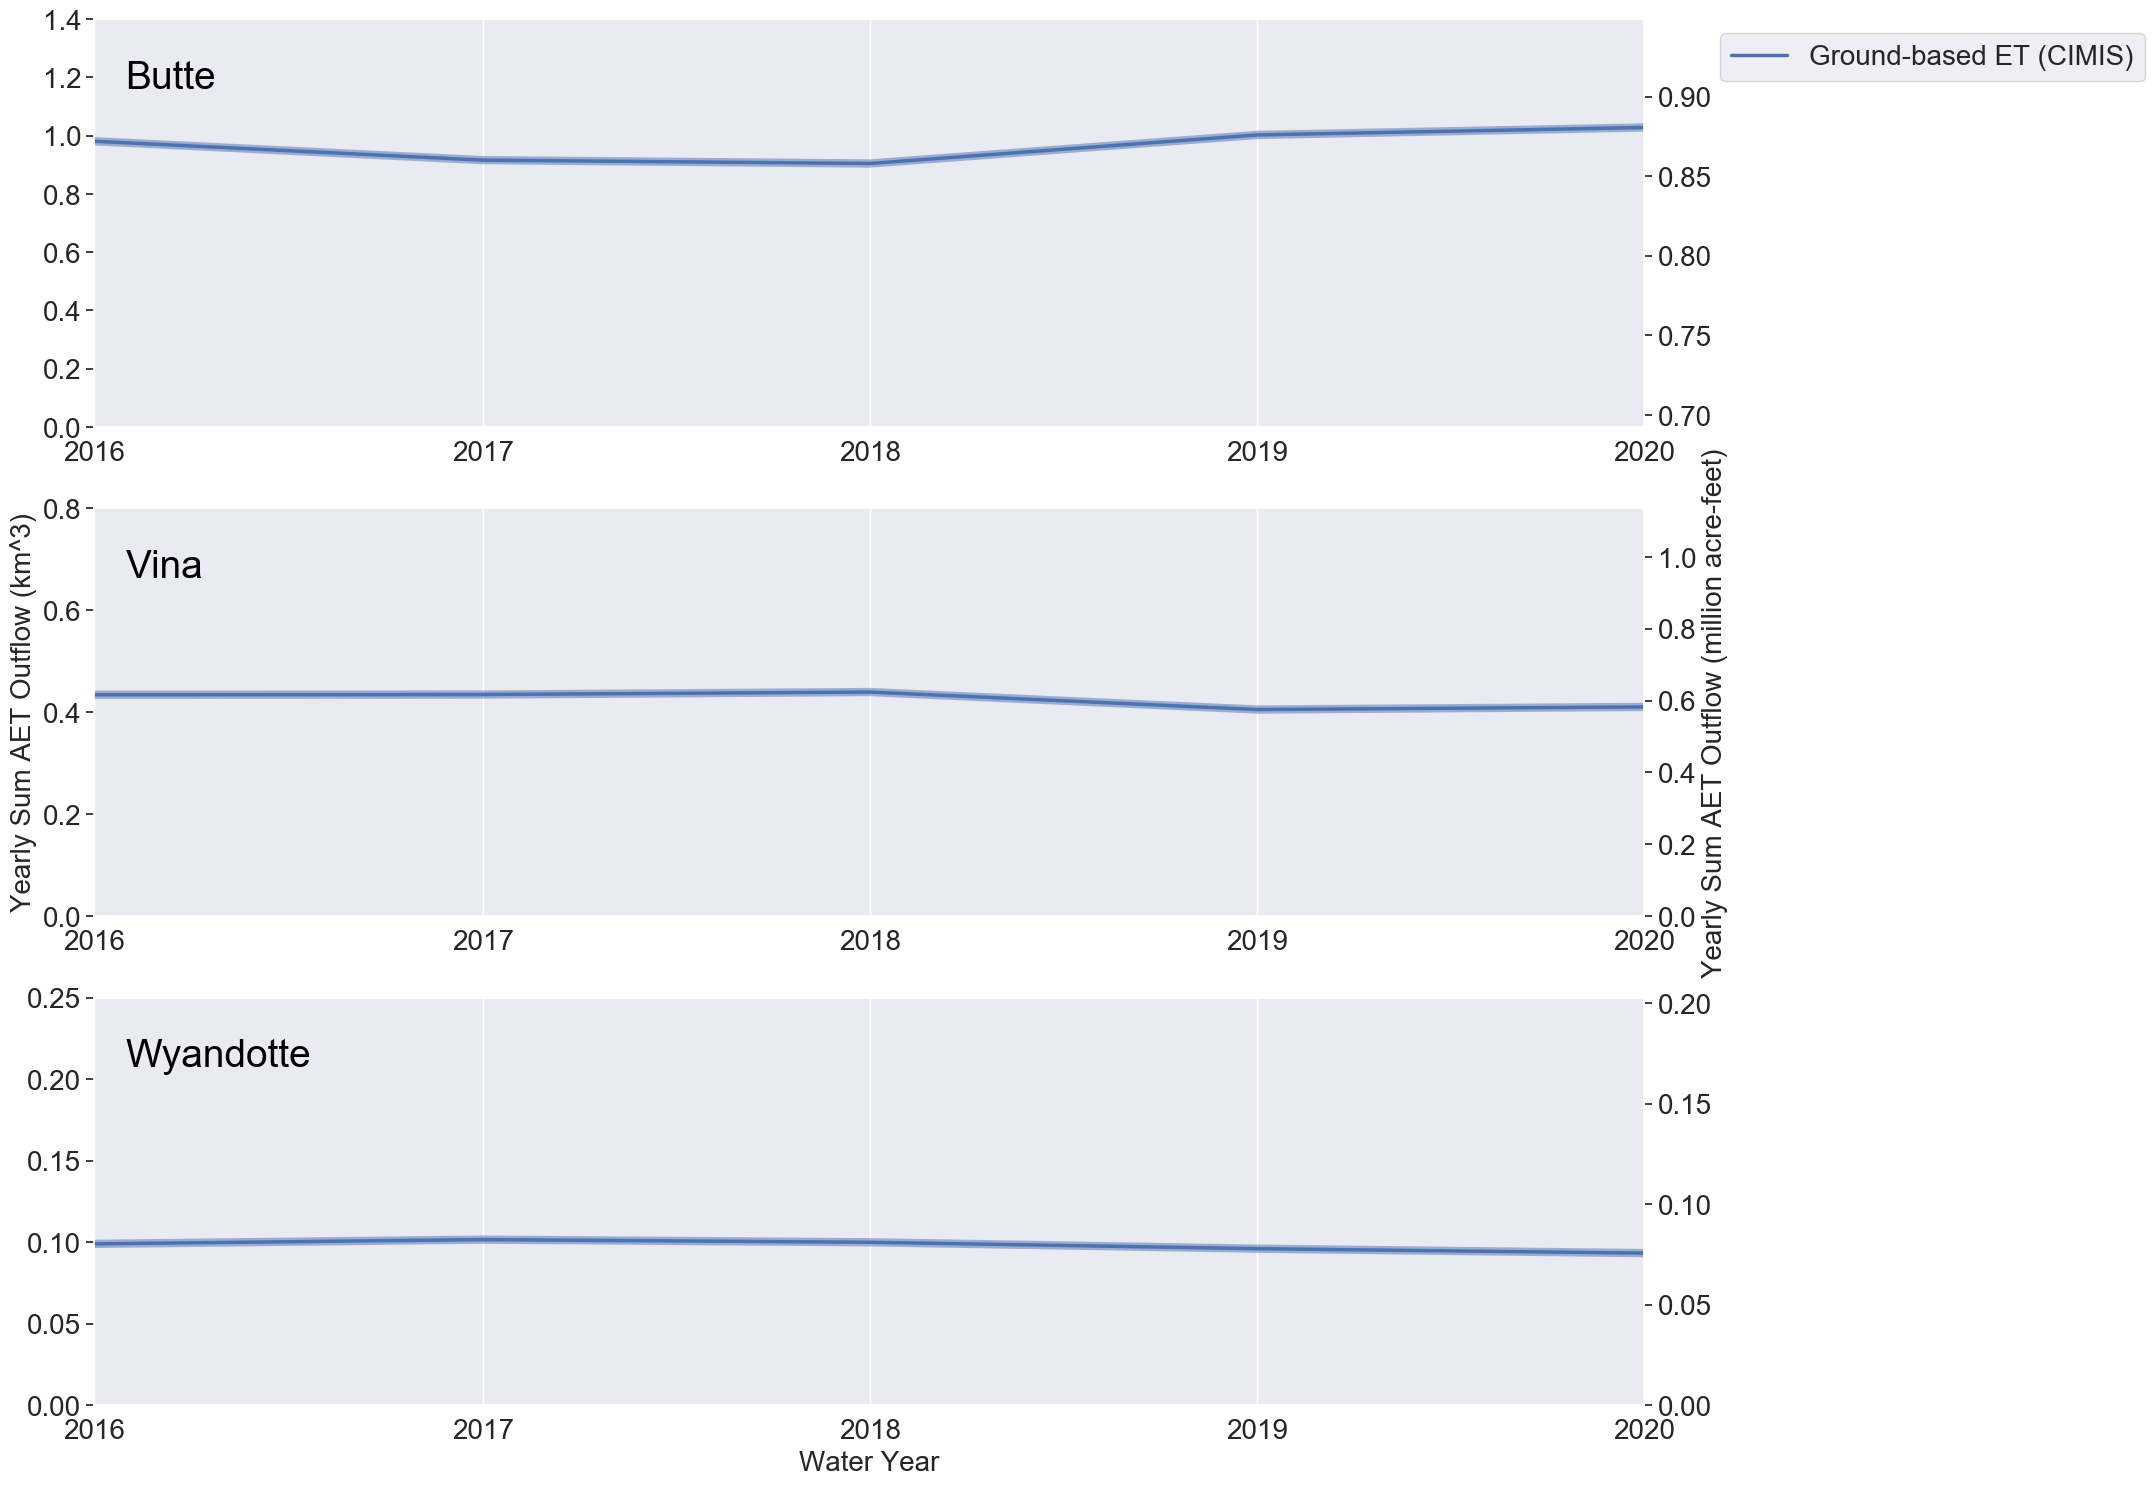

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(20,18))

# get left axis limits
axes[0].plot(b_sub_wb_aet_time, b_sub_wb_aet, label='Ground-based ET (CIMIS)', linewidth=2.5)
axes[0].plot(b_sub_wb_aet_time, b_sub_wb_aet,
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['ssebop'], 
#             label='SSEBop')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['MODkc'], 
#             label='MODkc')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['preferred'], 
#             label='Ahamed')


#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['DisALEXI_ET'], linewidth=2.5,
#             label='OpenET DisALEXI')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['PT-JPL_ET'], linewidth=2.5,
#             label='OpenET PT-JPL_ET')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['SIMS_ET'], linewidth=2.5,
#             label='OpenET SIMS')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['SSEBop_ET'], linewidth=2.5,
#             label='OpenET SSEBop')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['eeMETRIC_ET'], linewidth=2.5,
#             label='OpenET eeMETRIC')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['geeSEBAL_ET'], linewidth=2.5,
#             label='OpenET geeSEBAL')

#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_modis'], 
#             label='MOD16')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_gldas'], 
#             label='GLDAS')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_fldas'], 
#             label='FLDAS')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['aet_tc'], 
#             label='TerraClimate')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad'],
#        color=sns.color_palette()[8], alpha=1, label='OpenET Ensemble Mean')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad'], linewidth=6, color=sns.color_palette()[8])
#axes[0].fill_between(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['et_ensemble_mad_min'],
#                     aet_butte_yearly['et_ensemble_mad_max'], color=sns.color_palette()[8], alpha=0.5,
#                    label='Open ET Ensemble Range')


#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[0].text(0.02, 0.9, 'Butte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[0].transAxes,
        color='black', fontsize=28)
axes[0].set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2020,1,1))
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(dates.DateFormatter('%Y'))

axes_0_twin = axes[0].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
#axes[0].set_ylim(0, 1.4)
ymin, ymax = axes[0].get_ylim()
# apply function and set transformed values to right axis limits
axes_0_twin.set_ylim((af(ymin),af(ymax)))
axes_0_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_0_twin.plot([],[])
axes[0].set_zorder(axes_0_twin.get_zorder()+1)
axes[0].yaxis.grid(False)
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
#axes[0].set_xlabel('Water Year', fontsize=14)
#axes[0].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)
#axes[0].legend(fontsize=16)
axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=20)
axes[0].set_ylim([0,1.4])
axes[1].plot(v_sub_wb['WY'][12:31], v_sub_wb_et[12:31], label='Ground-based ET (CIMIS)', linewidth=2.5)
axes[1].plot(v_sub_wb['WY'][12:31], v_sub_wb_et[12:31],
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)

#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['ssebop'], 
#             label='Vina: SSEBop')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['MODkc'], 
#             label='Vina: MODkc')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['preferred'], 
#             label='Vina: Average of MODkc and SSEBop')


#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['DisALEXI_ET'], linewidth=2.5,
#             label='OpenET DisALEXI')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['PT-JPL_ET'], linewidth=2.5,
#             label='OpenET PT-JPL_ET')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['SIMS_ET'], linewidth=2.5,
#             label='OpenET SIMS')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['SSEBop_ET'], linewidth=2.5,
#             label='OpenET SSEBop')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['eeMETRIC_ET'], linewidth=2.5,
#             label='OpenET eeMETRIC')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['geeSEBAL_ET'], linewidth=2.5,
#             label='OpenET geeSEBAL')




#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_modis'], 
#             label='Vina: MOD16')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_gldas'], 
#             label='Vina: GLDAS')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_fldas'], 
#             label='Vina: FLDAS')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['aet_tc'], 
#             label='Vina: TerraClimate')

#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad'], linewidth=3.5,
#             label='Vina: OpenET Ensemble Mean')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad'], 
#        color=sns.color_palette()[8],linewidth=6, alpha=1)
#axes[1].fill_between(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['et_ensemble_mad_min'],
#                     aet_vina_yearly['et_ensemble_mad_max'], color=sns.color_palette()[8], alpha=0.5)

#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[1].text(0.02, 0.9, 'Vina',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[1].transAxes,
        color='black', fontsize=28)
axes[1].set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2020,1,1))   
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(dates.DateFormatter('%Y'))

axes_1_twin = axes[1].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
axes[1].set_ylim(0, 1.4)
ymin, ymax = axes[1].get_ylim()
# apply function and set transformed values to right axis limits
axes_1_twin.set_ylim((af(ymin),af(ymax)))
axes_1_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_1_twin.plot([],[])
axes_1_twin.set_ylabel('Yearly Sum AET Outflow (million acre-feet)', fontsize=20)
axes[1].set_zorder(axes_1_twin.get_zorder()+1)
axes[1].yaxis.grid(False)
             
#axes[1].grid()
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
#axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=20)
axes[1].set_ylim([0,0.8])
#axes[1].legend(fontsize=14, loc='upper left')
axes[2].plot(w_sub_wb['WY'][12:31], w_sub_wb_et[12:31], label='ET (CIMIS)', linewidth=2.5)
axes[2].plot(w_sub_wb['WY'][12:31], w_sub_wb_et[12:31],
        color=sns.color_palette()[0],linewidth=6, alpha=0.5)
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['ssebop'], 
#             label='Wyandotte: SSEBop')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['MODkc'], 
#             label='Wyandotte: MODkc')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['preferred'], 
#             label='Wyandotte: Average of MODkc and SSEBop')

#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['DisALEXI_ET'], linewidth=2.5,
#             label='OpenET DisALEXI')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['PT-JPL_ET'], linewidth=2.5,
#             label='OpenET PT-JPL_ET')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['SIMS_ET'], linewidth=2.5,
#             label='OpenET SIMS')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['SSEBop_ET'], linewidth=2.5,
#             label='OpenET SSEBop')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['eeMETRIC_ET'], linewidth=2.5,
#             label='OpenET eeMETRIC')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['geeSEBAL_ET'], linewidth=2.5,
#             label='OpenET geeSEBAL')





#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_modis'], 
#             label='Wyandotte: MOD16')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_gldas'], 
#             label='Wyandotte: GLDAS')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_fldas'], 
#             label='Wyandotte: FLDAS')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['aet_tc'], 
#             label='Wyandotte: TerraClimate')

#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad'], linewidth=3.5,
#             label='Wyandotte: OpenET Ensemble Mean')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad'],
#             color=sns.color_palette()[8], linewidth=6, alpha=1)
#axes[2].fill_between(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['et_ensemble_mad_max'],
#                     aet_wyandotte_yearly['et_ensemble_mad_min'], alpha=0.5, color=sns.color_palette()[8],
#                    label='Open ET Ensemble Range')

#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[2].text(0.02, 0.9, 'Wyandotte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[2].transAxes,
        color='black', fontsize=28)
axes[2].set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2020,1,1))
axes[2].xaxis.set_major_locator(mdates.YearLocator())
axes[2].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
#axes[2].grid()
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel('Water Year', fontsize=20)
#axes[2].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)

axes[2].set_ylim([0,0.25])
#axes[2].legend(fontsize=14, loc = 'upper left')


axes_2_twin = axes[2].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
#axes[2].set_ylim(0, 1.4)
ymin, ymax = axes[2].get_ylim()
# apply function and set transformed values to right axis limits
axes_2_twin.set_ylim((af(ymin),af(ymax)))
axes_2_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_2_twin.plot([],[])
axes[2].set_zorder(axes_2_twin.get_zorder()+1)
axes[2].yaxis.grid(False)

### Monthly ET



In [49]:
aet_butte_monthly.info()
aet_butte_yearly.info()

NameError: name 'aet_butte_monthly' is not defined

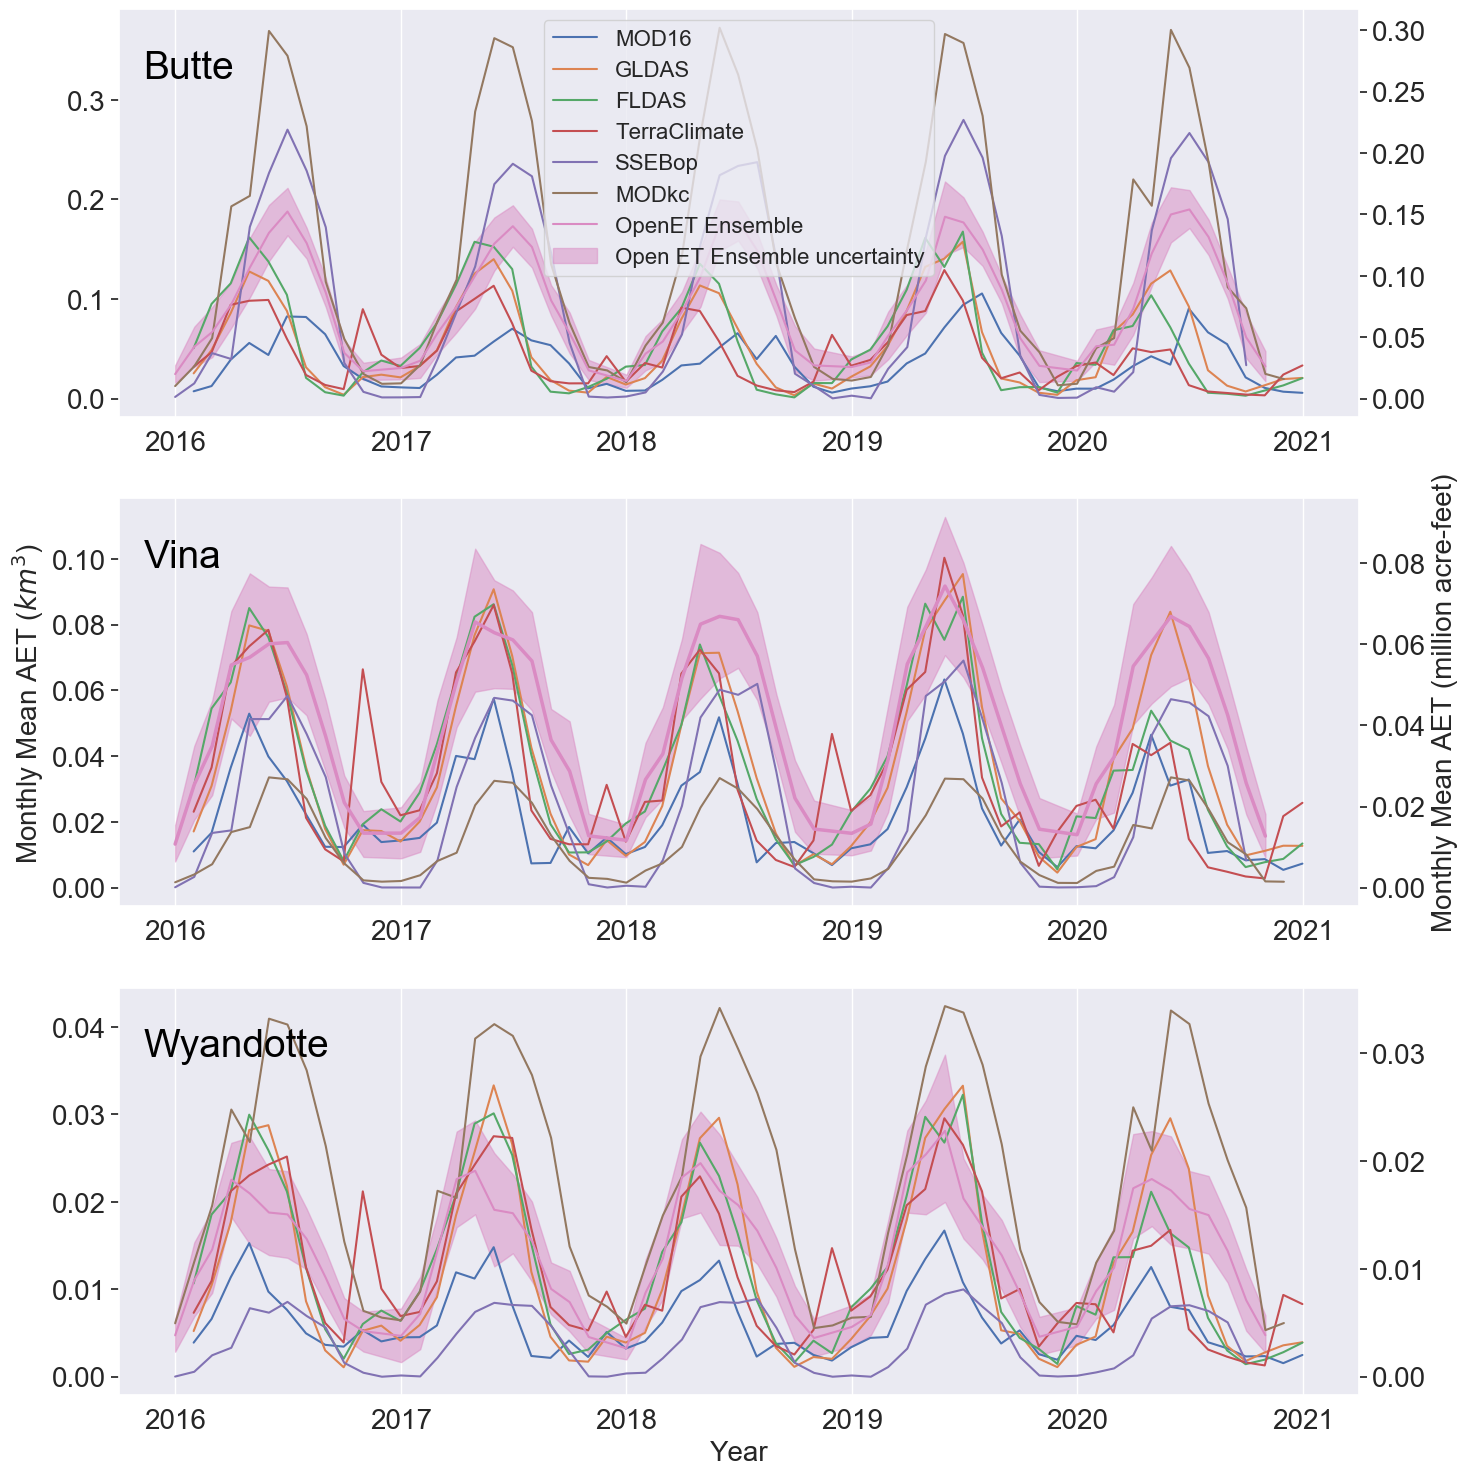

In [393]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

# get left axis limits
axes[0].plot(aet_butte.index, aet_butte['aet_modis'], 
             label='MOD16')
axes[0].plot(aet_butte.index, aet_butte['aet_gldas'], 
             label='GLDAS')
axes[0].plot(aet_butte.index, aet_butte['aet_fldas'], 
             label='FLDAS')
axes[0].plot(aet_butte.index, aet_butte['aet_tc'], 
             label='TerraClimate')
axes[0].plot(aet_butte_ssebop.index, aet_butte_ssebop['ssebop'], 
             label='SSEBop')
axes[0].plot(aet_butte_modkc.index, aet_butte_modkc['MODkc'], 
             label='MODkc')
axes[0].plot(aet_butte_openet.index, aet_butte_openet['et_ensemble_mad'],
             label='OpenET Ensemble')
axes[0].fill_between(aet_butte_openet.index, aet_butte_openet['et_ensemble_mad_min'],
                     aet_butte_openet['et_ensemble_mad_max'], color=sns.color_palette()[6], alpha=0.5,
                    label='Open ET Ensemble uncertainty')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[0].plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[0].text(0.02, 0.9, 'Butte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[0].transAxes,
        color='black', fontsize=28)
axes_0_twin = axes[0].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[0].get_ylim()
# apply function and set transformed values to right axis limits
axes_0_twin.set_ylim((af(ymin),af(ymax)))
axes_0_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_0_twin.plot([],[])
axes[0].set_zorder(axes_0_twin.get_zorder()+1)
axes[0].yaxis.grid(False)
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
#axes[0].set_xlabel('Water Year', fontsize=14)
#axes[0].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)
axes[0].legend(fontsize=16, loc='upper center')
#axes[0].set_ylim([0,1.7])
axes[1].plot(aet_vina.index, aet_vina['aet_modis'], 
             label='Vina: MOD16')
axes[1].plot(aet_vina.index, aet_vina['aet_gldas'], 
             label='Vina: GLDAS')
axes[1].plot(aet_vina.index, aet_vina['aet_fldas'], 
             label='Vina: FLDAS')
axes[1].plot(aet_vina.index, aet_vina['aet_tc'], 
             label='Vina: TerraClimate')
axes[1].plot(aet_vina_ssebop.index, aet_vina_ssebop['ssebop'], 
             label='Vina: SSEBop')
axes[1].plot(aet_vina_modkc.index, aet_vina_modkc['MODkc'], 
             label='Vina: MODkc')
axes[1].plot(aet_vina_openet.index, aet_vina_openet['et_ensemble_mad'], linewidth=2.5,
             label='Vina: OpenET Ensemble')
axes[1].fill_between(aet_vina_openet.index, aet_vina_openet['et_ensemble_mad_min'],
                     aet_vina_openet['et_ensemble_mad_max'], color=sns.color_palette()[6], alpha=0.5)
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[1].plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[1].text(0.02, 0.9, 'Vina',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[1].transAxes,
        color='black', fontsize=28)
        
axes_1_twin = axes[1].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[1].get_ylim()
# apply function and set transformed values to right axis limits
axes_1_twin.set_ylim((af(ymin),af(ymax)))
axes_1_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_1_twin.plot([],[])
axes_1_twin.set_ylabel('Monthly Mean AET (million acre-feet)', fontsize=20)
axes[1].set_zorder(axes_1_twin.get_zorder()+1)
axes[1].yaxis.grid(False)
             
#axes[1].grid()
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
#axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Monthly Mean AET ($km^3$)', fontsize=20)
#axes[1].set_ylim([0,1.7])
#axes[1].legend(fontsize=14, loc='upper left')
axes[2].plot(aet_wyandotte.index, aet_wyandotte['aet_modis'], 
             label='Wyandotte: MOD16')
axes[2].plot(aet_wyandotte.index, aet_wyandotte['aet_gldas'], 
             label='Wyandotte: GLDAS')
axes[2].plot(aet_wyandotte.index, aet_wyandotte['aet_fldas'], 
             label='Wyandotte: FLDAS')
axes[2].plot(aet_wyandotte.index, aet_wyandotte['aet_tc'], 
             label='Wyandotte: TerraClimate')
axes[2].plot(aet_wyandotte_ssebop.index, aet_wyandotte_ssebop['ssebop'], 
             label='Wyandotte: SSEBop')
axes[2].plot(aet_wyandotte_modkc.index, aet_wyandotte_modkc['MODkc'], 
             label='Wyandotte: MODkc')
axes[2].plot(aet_wyandotte_openet.index, aet_wyandotte_openet['et_ensemble_mad'],
             label='Wyandotte: OpenET Ensemble')
axes[2].fill_between(aet_wyandotte_openet.index, aet_wyandotte_openet['et_ensemble_mad_max'],
                     aet_wyandotte_openet['et_ensemble_mad_min'], color=sns.color_palette()[6], alpha=0.5,
                    label='Open ET Ensemble uncertainty')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], linewidth=2.5,
#             label='Average')
#axes[2].plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['average'], 
#        color=sns.color_palette()[9],linewidth=6, alpha=0.5)
axes[2].text(0.02, 0.9, 'Wyandotte',
        verticalalignment='top', horizontalalignment='left',
        transform=axes[2].transAxes,
        color='black', fontsize=28)
#axes[2].grid()
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel('Year', fontsize=20)
#axes[2].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)

#axes[1].set_ylim([0,1.7])
#axes[2].legend(fontsize=14, loc = 'upper left')

axes_2_twin = axes[2].twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes[2].get_ylim()
# apply function and set transformed values to right axis limits
axes_2_twin.set_ylim((af(ymin),af(ymax)))
axes_2_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_2_twin.plot([],[])
axes[2].set_zorder(axes_2_twin.get_zorder()+1)
axes[2].yaxis.grid(False)

In [394]:
max_envelope = np.max([aet_butte_yearly['pet_modis']/area_bs_km2, aet_vina_yearly['pet_modis']/area_vs_km2,
                       aet_wyandotte_yearly['pet_modis']/area_ws_km2], axis=0)*1.05
min_envelope = np.min([aet_butte_yearly['pet_modis']/area_bs_km2, aet_vina_yearly['pet_modis']/area_vs_km2,
                       aet_wyandotte_yearly['pet_modis']/area_ws_km2], axis=0)*0.95

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(16,6))

# get left axis limits
axes.plot(aet_butte_yearly.index.to_timestamp(), aet_butte_yearly['pet_modis']/area_bs_km2, 
             label='Butte Normalized PET')
axes.plot(aet_vina_yearly.index.to_timestamp(), aet_vina_yearly['pet_modis']/area_vs_km2, 
             label='Vina Normalized PET')
axes.plot(aet_wyandotte_yearly.index.to_timestamp(), aet_wyandotte_yearly['pet_modis']/area_ws_km2, 
             label='Wyandotte Normalized PET')
#axes.plot(aet_butte_yearly.index.to_timestamp(), max_envelope, label='max envelope')
#axes.plot(aet_butte_yearly.index.to_timestamp(), min_envelope, label='min envelope')
axes.fill_between(aet_butte_yearly.index.to_timestamp(), min_envelope, max_envelope, color='red', alpha=0.1)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
axes.set_xlabel('Water Year', fontsize=20)

axes_twin = axes.twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = axes.get_ylim()
# apply function and set transformed values to right axis limits
axes_twin.set_ylim((af(ymin),af(ymax)))
axes_twin.tick_params(axis='y', labelsize=20)
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
axes_twin.plot([],[])
axes.set_zorder(axes_0_twin.get_zorder()+1)
axes.yaxis.grid(False)
axes_twin.set_ylabel('Yearly Sum AET Outflow (million acre-feet)', fontsize=20)
axes.set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=20)
axes.legend(fontsize=16)

In [ ]:
butte_aet = np.array(b_sub_wb_aet)
average_aet = np.array(aet_butte_yearly['average'])
print("Butte Average vs. Butte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((average_aet-butte_aet)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((average_aet-butte_aet)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((average_aet-butte_aet)/butte_aet)*100))
print("")
butte_aet_last_5 = butte_aet[-5:]
open_aet = np.array(aet_butte_yearly['openet'][-5:])
print("Butte OpenET vs. Butte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((open_aet-butte_aet_last_5)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((open_aet-butte_aet_last_5)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((open_aet-butte_aet_last_5)/butte_aet_last_5)*100))
print("")
print("")

vina_aet = np.array(v_sub_wb_aet)
average_aet = np.array(aet_vina_yearly['average'])
print("Vina Average vs. Vina:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((average_aet-vina_aet)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((average_aet-vina_aet)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((average_aet-vina_aet)/vina_aet)*100))
print("")
vina_aet_last_5 = vina_aet[-5:]
open_aet = np.array(aet_vina_yearly['openet'][-5:])
print("Vina OpenET vs. Vina:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((open_aet-vina_aet_last_5)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((open_aet-vina_aet_last_5)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((open_aet-vina_aet_last_5)/vina_aet_last_5)*100))
print("")
print("")

wyandotte_aet = np.array(w_sub_wb_aet)
average_aet = np.array(aet_wyandotte_yearly['average'])
print("Wyandotte Average vs. Wyandotte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((average_aet-wyandotte_aet)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((average_aet-wyandotte_aet)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((average_aet-wyandotte_aet)/wyandotte_aet)*100))
print("")
wyandotte_aet_last_5 = wyandotte_aet[-5:]
open_aet = np.array(aet_wyandotte_yearly['openet'][-5:])
print("Wyandotte OpenET vs. Wyandotte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((open_aet-wyandotte_aet_last_5)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((open_aet-wyandotte_aet_last_5)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((open_aet-wyandotte_aet_last_5)/wyandotte_aet_last_5)*100))
print("")
print("")

# Compare PET (for Uncertainty)

In [43]:
modis_pet = xr.open_dataset('../data/Butte_PET/Butte_MODIS_PET.nc')

In [44]:
modis_pet

<xarray.Dataset>
Dimensions:  (time: 965, x: 446, y: 446)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2021-12-27
  * y        (y) float64 40.5 40.49 40.49 40.48 40.48 ... 38.51 38.51 38.5 38.5
  * x        (x) float64 -123.0 -123.0 -123.0 -123.0 ... -121.0 -121.0 -121.0
Data variables:
    PET      (time, y, x) float64 ...
Attributes:
    transform:               [ 4.49157642e-03  0.00000000e+00 -1.23001820e+02...
    crs:                     +init=epsg:4326
    res:                     [0.00449158 0.00449158]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [45]:
modis_pet_closest = modis_pet.sel(x=-121.82443, y=39.608639, method='nearest')*0.1*area_km2*1e-6

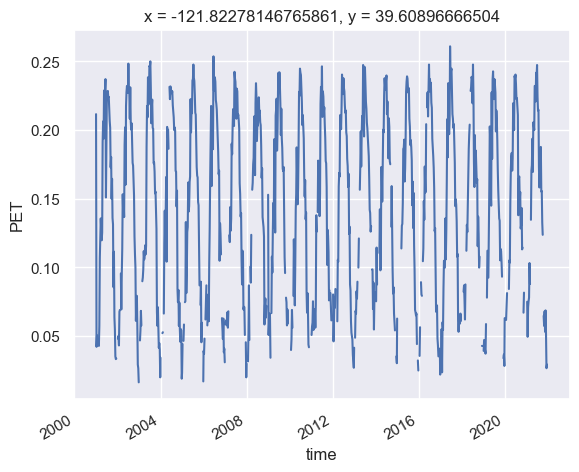

In [46]:
modis_pet_closest['PET'].plot()

In [47]:
modis_pet.rio.write_crs(4326, inplace=True)
modis_pet.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
modis_pet_clipped = modis_pet.rio.clip(
    area.geometry.apply(mapping), area.crs, drop=False)

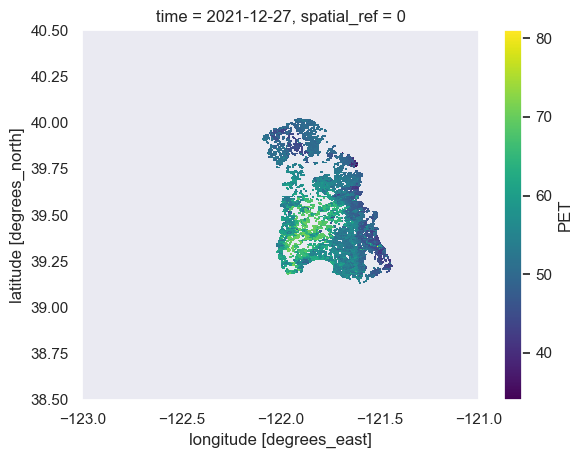

In [48]:
modis_pet_clipped['PET'].isel(time=-1).plot()

In [49]:
modis_pet_clipped_average = modis_pet_clipped.mean(['x','y'])*0.1*area_km2*1e-6
modis_pet_clipped_min = modis_pet_clipped.min(['x','y'])*0.1*area_km2*1e-6
modis_pet_clipped_max = modis_pet_clipped.max(['x','y'])*0.1*area_km2*1e-6

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/xarray/core/nputils.py:222: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


In [50]:
modis_pet_clipped_average

<xarray.Dataset>
Dimensions:      (time: 965)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2021-12-27
    spatial_ref  int64 0
Data variables:
    PET          (time) float64 0.2049 0.03977 0.05628 ... 0.02829 0.01802

Text(0.5, 1.0, 'Comparing PET at CIMIS vs MODIS')

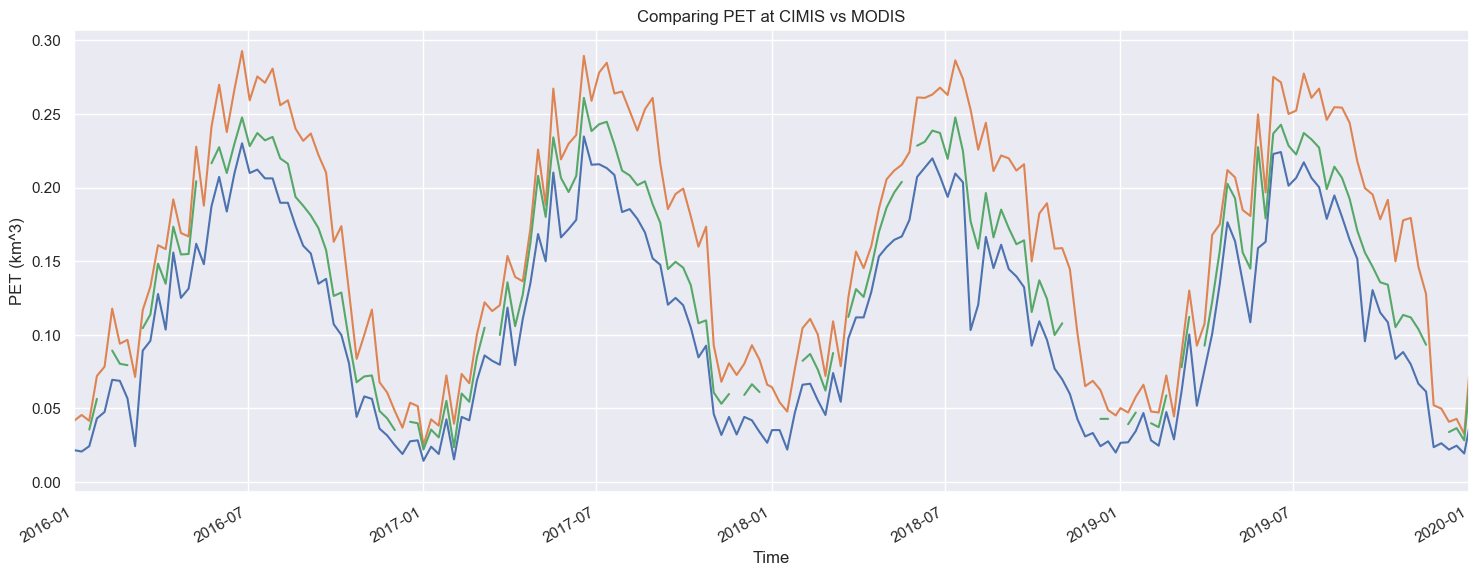

In [51]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
modis_pet_clipped_min['PET'].plot(ax=ax)
modis_pet_clipped_max['PET'].plot(ax=ax)
modis_pet_closest['PET'].plot(ax=ax)
ax.set_xlim(datetime.datetime(2016,1,1), datetime.datetime(2020,1,1))
ax.set_ylabel('PET (km^3)')
ax.set_xlabel('Time')
ax.set_title('Comparing PET at CIMIS vs MODIS')

In [52]:
import json
## not the most Pythonic but I am too lazy to glob
f = open('../data/Butte_PET/CIMIS_2001_2003')
cimis_2001_2003 = json.load(f)
cimis_2001_2003_dict = pd.DataFrame(cimis_2001_2003['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2004_2006')
cimis_2004_2006 = json.load(f)
cimis_2004_2006_dict = pd.DataFrame(cimis_2004_2006['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2007_2009')
cimis_2007_2009 = json.load(f)
cimis_2007_2009_dict = pd.DataFrame(cimis_2007_2009['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2010_2012')
cimis_2010_2012 = json.load(f)
cimis_2010_2012_dict = pd.DataFrame(cimis_2010_2012['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2013_2015')
cimis_2013_2015 = json.load(f)
cimis_2013_2015_dict = pd.DataFrame(cimis_2013_2015['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2016_2018')
cimis_2016_2018 = json.load(f)
cimis_2016_2018_dict = pd.DataFrame(cimis_2016_2018['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2019_2021')
cimis_2019_2021 = json.load(f)
cimis_2019_2021_dict = pd.DataFrame(cimis_2019_2021['Data']['Providers'][0]['Records'])
f = open('../data/Butte_PET/CIMIS_2022_2023')
cimis_2022_2023 = json.load(f)
cimis_2022_2023_dict = pd.DataFrame(cimis_2022_2023['Data']['Providers'][0]['Records'])

In [53]:
result = pd.concat([cimis_2001_2003_dict, cimis_2004_2006_dict, cimis_2007_2009_dict,
                   cimis_2010_2012_dict, cimis_2013_2015_dict, cimis_2016_2018_dict,
                   cimis_2019_2021_dict, cimis_2022_2023_dict], ignore_index=True, sort=False)

In [54]:

result['Datetime'] = pd.to_datetime(result['Date'])
result = result.set_index('Datetime')
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8095 entries, 2001-01-01 to 2023-03-01
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           8095 non-null   object
 1   Julian         8095 non-null   object
 2   Station        8095 non-null   object
 3   Standard       8095 non-null   object
 4   ZipCodes       8095 non-null   object
 5   Scope          8095 non-null   object
 6   DayAirTmpAvg   8095 non-null   object
 7   DayAirTmpMax   8095 non-null   object
 8   DayAirTmpMin   8095 non-null   object
 9   DayDewPnt      8095 non-null   object
 10  DayAsceEto     8095 non-null   object
 11  DayPrecip      8095 non-null   object
 12  DayRelHumAvg   8095 non-null   object
 13  DayRelHumMax   8095 non-null   object
 14  DayRelHumMin   8095 non-null   object
 15  DaySoilTmpAvg  8095 non-null   object
 16  DaySolRadAvg   8095 non-null   object
 17  DayVapPresAvg  8095 non-null   object
 18  DayWindRun

In [55]:
result = result.apply(pd.to_numeric, errors='ignore')

In [56]:
result['DayAsceEto']

Datetime
2001-01-01    {'Value': '0.04', 'Qc': ' ', 'Unit': '(in)'}
2001-01-02    {'Value': '0.05', 'Qc': ' ', 'Unit': '(in)'}
2001-01-03    {'Value': '0.05', 'Qc': ' ', 'Unit': '(in)'}
2001-01-04    {'Value': '0.06', 'Qc': 'R', 'Unit': '(in)'}
2001-01-05    {'Value': '0.06', 'Qc': ' ', 'Unit': '(in)'}
                                  ...                     
2023-02-25    {'Value': '0.02', 'Qc': ' ', 'Unit': '(in)'}
2023-02-26    {'Value': '0.01', 'Qc': ' ', 'Unit': '(in)'}
2023-02-27    {'Value': '0.04', 'Qc': ' ', 'Unit': '(in)'}
2023-02-28    {'Value': '0.04', 'Qc': ' ', 'Unit': '(in)'}
2023-03-01    {'Value': '0.11', 'Qc': ' ', 'Unit': '(in)'}
Name: DayAsceEto, Length: 8095, dtype: object

In [57]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

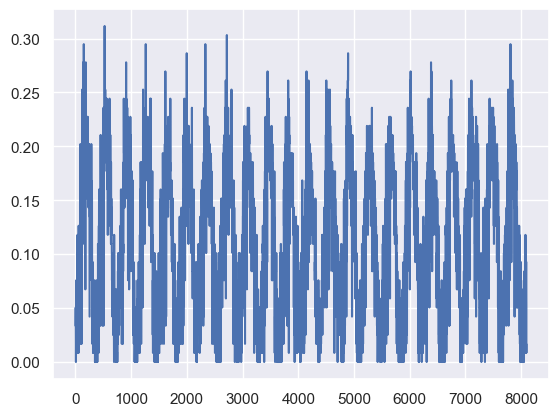

In [58]:
cimis_et = pd.DataFrame(result['DayAsceEto'].values.tolist())
cimis_et = cimis_et.apply(pd.to_numeric, errors='ignore')
cimis_et = cimis_et['Value']*25.4*area_km2*1e-6*10
cimis_et.plot()
cimis_et = cimis_et.to_numpy()
cimis_et = moving_average(cimis_et, 10)

In [59]:
cimis_et_dataframe = pd.DataFrame(index=result.index)
cimis_et_dataframe['Value'] = cimis_et

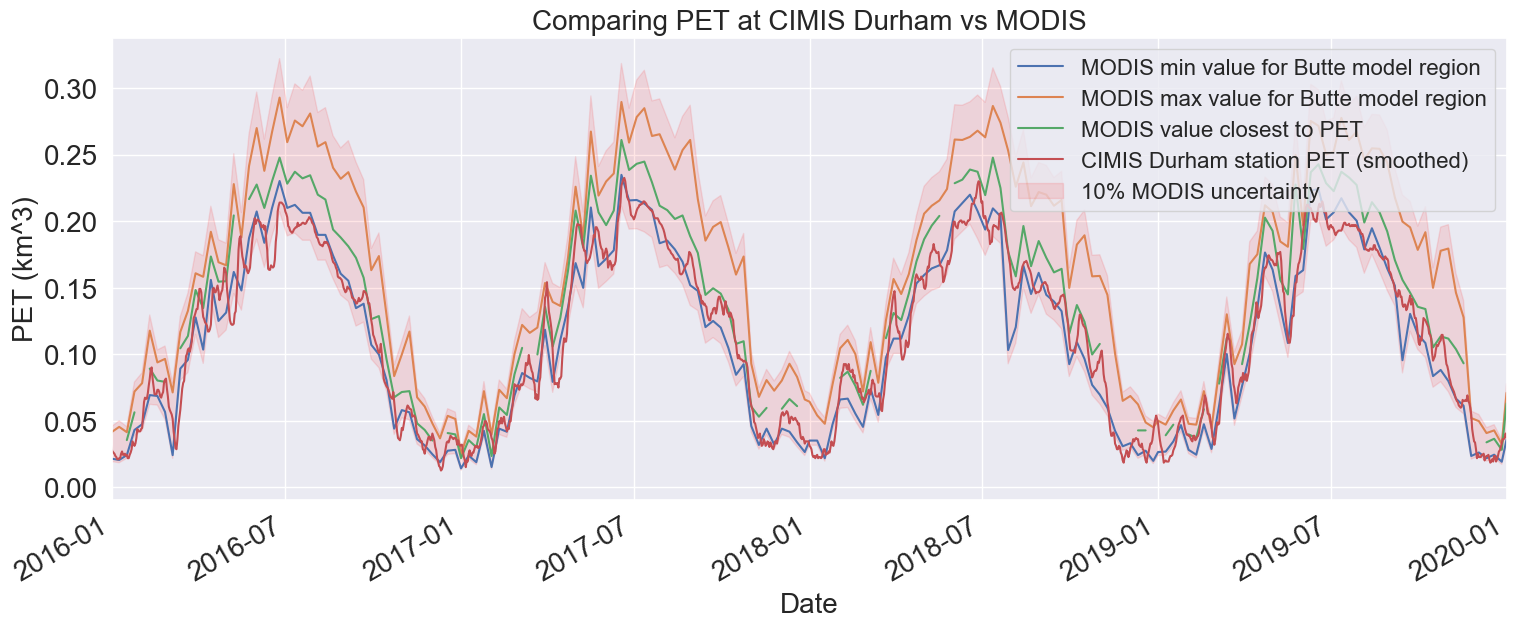

In [63]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
modis_pet_clipped_min['PET'].plot(ax=ax, label='MODIS min value for Butte model region')
modis_pet_clipped_max['PET'].plot(ax=ax, label='MODIS max value for Butte model region')
modis_pet_closest['PET'].plot(ax=ax, label='MODIS value closest to PET')
ax.fill_between(x=modis_pet_clipped_min.time,
                  y1=modis_pet_clipped_max['PET']*1.10,
                  y2=modis_pet_clipped_min['PET']*0.90,
                color='red', alpha=0.1, label='10% MODIS uncertainty')
ax.plot(cimis_et_dataframe.index, cimis_et_dataframe['Value'], label='CIMIS Durham station PET (smoothed)')
ax.set_xlim(datetime.datetime(2016,1,1), datetime.datetime(2020,1,1))
ax.set_ylabel('PET (km^3)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('Comparing PET at CIMIS Durham vs MODIS', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(fontsize=16)

Text(0.5, 1.0, 'Comparing PET at CIMIS vs MODIS')

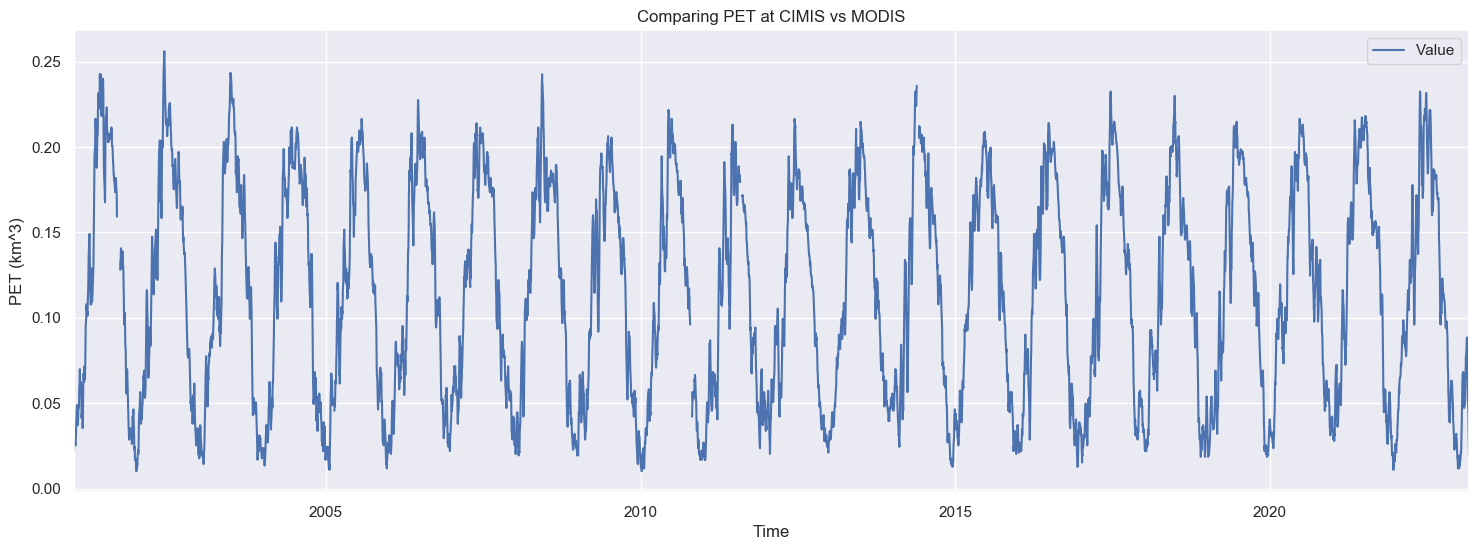

In [61]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
cimis_et_dataframe.plot(ax=ax)
ax.set_ylabel('PET (km^3)')
ax.set_xlabel('Time')
ax.set_title('Comparing PET at CIMIS vs MODIS')

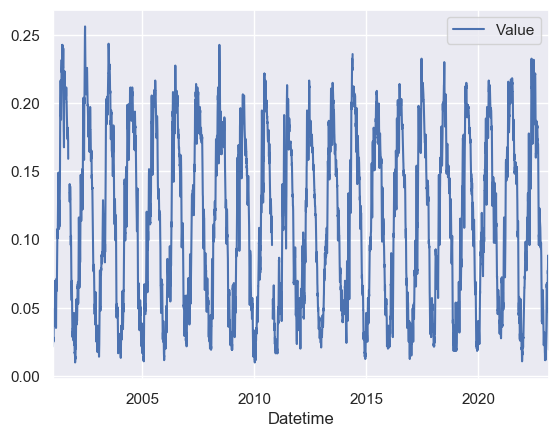

In [62]:
cimis_et_dataframe.plot(y='Value')

In [ ]:
cimis_dict = pd.DataFrame(cimis_2001_2003['Data']['Providers'][0]['Records'])

In [ ]:
cimis_dict.info()

# Streamflow IN

In [ ]:
w_sub_wb.info()

In [ ]:
# Diversions
butte_diversions_in = (b_sub_wb['Butte Creek']+b_sub_wb['Outside']+b_sub_wb['Sac River'])*1.23348e-6
vina_diversions_in = (v_sub_wb['Sac River']+v_sub_wb['Outside'])*1.23348e-6
wyandotte_diversions_in = w_sub_wb['Outside']*1.23348e-6
# Streams
butte_streams_in = (b_sub_wb['Little Chico Creek into Butte']+b_sub_wb['Butte Creek into Butte']+b_sub_wb[
    'Little Dry Creek into Butte']+b_sub_wb['Dry Creek into Butte'])*1.23348e-6
vina_streams_in = (v_sub_wb['Singer Creek into Vina'] + v_sub_wb['Pine Creek into Vina'] + v_sub_wb[
    'Rock Creek into Vina'] + v_sub_wb['Mud Creek into Vina'] + v_sub_wb[
    'Big Chico Creek into Vina'] + v_sub_wb['Little Chico Creek into Vina'] + v_sub_wb[
    'Butte Creek into Vina'] + v_sub_wb['Little Dry Creek into Vina'] + v_sub_wb[
    'Dry Creek into Vina'])*1.23348e-6
wyandotte_streams_in = (w_sub_wb['Feather River into Wyandotte Creek'] + w_sub_wb[
    'North Honcut Creek into Wyandotte Creek'])*1.23348e-6
# Runoff from upslope basins
butte_runoff_in = (b_sub_wb['From Vina'] + b_sub_wb['From Wyandotte'] + b_sub_wb['From Foothills'] + b_sub_wb[
    'From Sutter'])*1.23348e-6
vina_runoff_in = (v_sub_wb['From Foothills'] + v_sub_wb['From Los Molinos'])*1.23348e-6
wyandotte_runoff_in = w_sub_wb['From Foothills']*1.23348e-6
# SW Return Flow
butte_sw_return_in = (b_sub_wb['From Vina.1'] + b_sub_wb['From Wyandotte.1'] + b_sub_wb['From Foothills.1'] + b_sub_wb[
    'From Sutter.1'])*1.23348e-6
vina_sw_return_in = (v_sub_wb['From Foothills.1'] + v_sub_wb['From Los Molinos.1'])*1.23348e-6
wyandotte_sw_return_in = w_sub_wb['From Foothills.1']*1.23348e-6
# GW Return Flow
butte_gw_return_in = (b_sub_wb['From Vina.2'] + b_sub_wb['From Wyandotte.2'] + b_sub_wb['From Foothills.2'] + b_sub_wb[
    'From Sutter.2'])*1.23348e-6
vina_gw_return_in = (v_sub_wb['From Foothills.2'] + v_sub_wb['From Los Molinos.2'])*1.23348e-6
wyandotte_gw_return_in = w_sub_wb['From Foothills.2']*1.23348e-6
# Other
butte_other_in = b_sub_wb['Other Inflows']*1.23348e-6
vina_other_in = v_sub_wb['Other Inflow']*1.23348e-6

# GW Flow
butte_q_gw_in = b_sub_wb['Subsurface Inflows']*1.23348e-6
# Total In
butte_q_in = (butte_diversions_in + butte_streams_in + butte_sw_return_in + 
              butte_gw_return_in + butte_other_in)
vina_q_in = (vina_diversions_in + vina_streams_in + vina_runoff_in + vina_sw_return_in +
            vina_gw_return_in + vina_other_in)
wyandotte_q_in = (wyandotte_diversions_in + wyandotte_streams_in + wyandotte_runoff_in +
                 wyandotte_sw_return_in + wyandotte_gw_return_in)

butte_q_in_file = np.array([b_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), butte_q_in[11:32]]).T
np.savetxt('../data/butte_inflow.csv', butte_q_in_file, delimiter=',', fmt='%s')

butte_q_gw_in_file = np.array([b_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), butte_q_gw_in[11:32]]).T
np.savetxt('../data/butte_gw_inflow.csv', butte_q_gw_in_file, delimiter=',', fmt='%s')

butte_runoff_in_file = np.array([b_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), butte_runoff_in[11:32]]).T
np.savetxt('../data/butte_runoff_inflow.csv', butte_runoff_in_file, delimiter=',', fmt='%s')

vina_q_in_file = np.array([v_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), vina_q_in[11:32]]).T
np.savetxt('../data/vina_inflow.csv', vina_q_in_file, delimiter=',', fmt='%s')
wyandotte_q_in_file = np.array([w_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), wyandotte_q_in[11:32]]).T
np.savetxt('../data/wyandotte_inflow.csv', wyandotte_q_in_file, delimiter=',', fmt='%s')

# Streamflow OUT

In [ ]:
# Streams
butte_streams_out = (b_sub_wb['Cherokee Canal out of Butte']+b_sub_wb['Butte Creek out of Butte'])*1.23348e-6
vina_streams_out = (v_sub_wb['Pine Creek out of Vina'] + v_sub_wb['Mud Creek out of Vina'] + v_sub_wb[
    'Big Chico Creek out of Vina'] + v_sub_wb['Little Chico Creek into Butte'] + v_sub_wb[
    'Butte Creek into Vina'] + v_sub_wb['Little Dry Creek into Butte'] + v_sub_wb[
    'Dry Creek into Butte'])*1.23348e-6
wyandotte_streams_out = w_sub_wb['Feather River out of Wyandotte Creek']*1.23348e-6
# Runoff
butte_runoff_out = b_sub_wb['To Outside']*1.23348e-6
vina_runoff_out = (v_sub_wb['To Butte'] + v_sub_wb['To Outside'])*1.23348e-6
wyandotte_runoff_out = (w_sub_wb['To Butte'] + w_sub_wb['To Outside'])*1.23348e-6
# SW Return Flow
butte_sw_return_out = b_sub_wb['To Outside.1']*1.23348e-6
vina_sw_return_out = (v_sub_wb['To Butte.1'] + v_sub_wb['To Outside.1'])*1.23348e-6
wyandotte_sw_return_out = (w_sub_wb['To Butte.1'] + w_sub_wb['To Outside.1'])*1.23348e-6
# GW Return Flow
butte_gw_return_out = b_sub_wb['To Outside.2']*1.23348e-6
vina_gw_return_out = (v_sub_wb['To Butte.2'] + v_sub_wb['To Outside.2'])*1.23348e-6
wyandotte_gw_return_out = (w_sub_wb['To Butte.2'] + w_sub_wb['To Outside.2'])*1.23348e-6
# Diversions
butte_diversions_out = b_sub_wb['Butte Creek To Sutter']*1.23348e-6
vina_diversions_out = v_sub_wb['Butte Creek To Butte']*1.23348e-6
# Other
butte_other_out = b_sub_wb['Other Outflows']*1.23348e-6
vina_other_out = v_sub_wb['Other Outflow']*1.23348e-6

# GW Flow

butte_q_gw_out = b_sub_wb['Subsurface Outflows']*1.23348e-6

# Total Out
butte_q_out = (butte_diversions_out + butte_streams_out + butte_sw_return_out + 
              butte_gw_return_out + butte_other_out)
vina_q_out = (vina_diversions_out + vina_streams_out + vina_runoff_out + vina_sw_return_out +
             vina_gw_return_out + vina_other_out)
wyandotte_q_out = (wyandotte_streams_out + wyandotte_runoff_out + wyandotte_sw_return_out +
                  wyandotte_gw_return_out)
butte_q_out_file = np.array([b_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), butte_q_out[11:32]]).T
np.savetxt('../data/butte_outflow.csv', butte_q_out_file, delimiter=',', fmt='%s')

butte_q_gw_out_file = np.array([b_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), butte_q_gw_out[11:32]]).T
np.savetxt('../data/butte_gw_outflow.csv', butte_q_gw_out_file, delimiter=',', fmt='%s')

butte_runoff_out_file = np.array([b_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), butte_runoff_out[11:32]]).T
np.savetxt('../data/butte_runoff_outflow.csv', butte_runoff_out_file, delimiter=',', fmt='%s')

vina_q_out_file = np.array([v_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), vina_q_out[11:32]]).T
np.savetxt('../data/vina_outflow.csv', vina_q_out_file, delimiter=',', fmt='%s')
wyandotte_q_out_file = np.array([w_sub_wb['WY'][11:32].dt.strftime(date_format='%m/%d/%Y'), wyandotte_q_out[11:32]]).T
np.savetxt('../data/wyandotte_outflow.csv', wyandotte_q_out_file, delimiter=',', fmt='%s')

# Change in Groundwater Storage

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

axes[0].plot(b_sub_wb['WY'][11:30], butte_diversions_in[11:30], label='Butte: Q In (Diversions)')
axes[0].plot(b_sub_wb['WY'][11:30], butte_streams_in[11:30], label='Butte: Q In (Streams)')
axes[0].plot(b_sub_wb['WY'][11:30], butte_runoff_in[11:30], label='Butte: Q In (Runoff)')
axes[0].plot(b_sub_wb['WY'][11:30], butte_sw_return_in[11:30], label='Butte: Q In (SW Return Flow)')
axes[0].plot(b_sub_wb['WY'][11:30], butte_gw_return_in[11:30], label='Butte: Q In (GW Return Flow)')
axes[0].plot(b_sub_wb['WY'][11:30], butte_other_in[11:30], label='Butte: Q In (Other)')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_xlabel('Water Year', fontsize=14)
axes[0].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[0].legend(fontsize=14, loc='upper left')

axes[1].plot(b_sub_wb['WY'][11:30], butte_diversions_out[11:30], label='Butte: Q Out (Diversions)')
axes[1].plot(b_sub_wb['WY'][11:30], butte_streams_out[11:30], label='Butte: Q Out (Streams)')
axes[1].plot(b_sub_wb['WY'][11:30], butte_runoff_out[11:30], label='Butte: Q Out (Runoff)')
axes[1].plot(b_sub_wb['WY'][11:30], butte_sw_return_out[11:30], label='Butte: Q Out (SW Return Flow)')
axes[1].plot(b_sub_wb['WY'][11:30], butte_gw_return_out[11:30], label='Butte: Q Out (GW Return Flow)')
axes[1].plot(b_sub_wb['WY'][11:30], butte_other_out[11:30], label='Butte: Q Out (Other)')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[1].legend(fontsize=14, loc='upper left')

axes[2].plot(b_sub_wb['WY'][11:30], butte_q_in[11:30], label='Butte: Q In (Total)')
axes[2].plot(b_sub_wb['WY'][11:30], butte_q_out[11:30], label='Butte: Q Out (Total)')
axes[2].plot(v_sub_wb['WY'][11:30], vina_q_in[11:30], label='Vina: Q In (Total)')
axes[2].plot(v_sub_wb['WY'][11:30], vina_q_out[11:30], label='Vina: Q Out (Total)')
axes[2].plot(w_sub_wb['WY'][11:30], wyandotte_q_in[11:30], label='Wyandotte: Q In (Total)')
#axes[2].plot(w_sub_wb['WY'][11:30], wyandotte_q_out[11:30], label='Wyandotte: Q Out (Total)')
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_xlabel('Water Year', fontsize=14)
axes[2].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[2].legend(fontsize=14, loc='upper left')


'''
#axes[0].grid()
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_xlabel('Water Year', fontsize=14)
axes[0].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)

#axes[0].set_ylim([0,1.7])
axes[1].plot(v_sub_wb['WY'][11:30], v_sub_wb_et[11:30], label='Vina: BBGM ET (CIMIS)')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['aet_modis'][:-2], 
             label='Vina: MOD16')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['aet_gldas'][:-2], 
             label='Vina: GLDAS')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['aet_fldas'][:-2], 
             label='Vina: FLDAS')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['aet_tc'][:-2], 
             label='Vina: TerraClimate')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['ssebop'][:-2], 
             label='Vina: SSEBop')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['MODkc'][:-2], 
             label='Vina: MODkc')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['average'][:-2], 
             label='Vina: Average of MODIS, GLDAS, TC, RLDAS')
axes[1].plot(aet_vina_yearly.index.to_timestamp()[:-2], aet_vina_yearly['preferred'][:-2], 
             label='Vina: Average of MODkc and SSEBop')
#axes[1].grid()
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)
#axes[1].set_ylim([0,1.7])
axes[1].legend(fontsize=14)
axes[2].plot(w_sub_wb['WY'][11:30], w_sub_wb_et[11:30], label='Wyandotte: BBGM ET (CIMIS)')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['aet_modis'][:-2], 
             label='Wyandotte: MOD16')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['aet_gldas'][:-2], 
             label='Wyandotte: GLDAS')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['aet_fldas'][:-2], 
             label='Wyandotte: FLDAS')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['aet_tc'][:-2], 
             label='Wyandotte: TerraClimate')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['ssebop'][:-2], 
             label='Wyandotte: SSEBop')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['MODkc'][:-2], 
             label='Wyandotte: MODkc')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['average'][:-2], 
             label='Wyandotte: Average of MODIS, GLDAS, TC, RLDAS')
axes[2].plot(aet_wyandotte_yearly.index.to_timestamp()[:-2], aet_wyandotte_yearly['preferred'][:-2], 
             label='Wyandotte: Average of MODkc and SSEBop')
#axes[2].grid()
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_xlabel('Water Year', fontsize=14)
axes[2].set_ylabel('Yearly Sum AET Outflow (km^3)', fontsize=14)

#axes[1].set_ylim([0,1.7])
axes[2].legend(fontsize=14)
'''

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

axes[0].plot(v_sub_wb['WY'][11:30], vina_diversions_in[11:30], label='Vina: Q In (Diversions)')
axes[0].plot(v_sub_wb['WY'][11:30], vina_streams_in[11:30], label='Vina: Q In (Streams)')
axes[0].plot(v_sub_wb['WY'][11:30], vina_runoff_in[11:30], label='Vina: Q In (Runoff)')
axes[0].plot(v_sub_wb['WY'][11:30], vina_sw_return_in[11:30], label='Vina: Q In (SW Return Flow)')
axes[0].plot(v_sub_wb['WY'][11:30], vina_gw_return_in[11:30], label='Vina: Q In (GW Return Flow)')
axes[0].plot(v_sub_wb['WY'][11:30], vina_other_in[11:30], label='Vina: Q In (Other)')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_xlabel('Water Year', fontsize=14)
axes[0].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[0].legend(fontsize=14, loc='upper left')

axes[1].plot(v_sub_wb['WY'][11:30], vina_diversions_out[11:30], label='Vina: Q Out (Diversions)')
axes[1].plot(v_sub_wb['WY'][11:30], vina_streams_out[11:30], label='Vina: Q Out (Streams)')
axes[1].plot(v_sub_wb['WY'][11:30], vina_runoff_out[11:30], label='Vina: Q Out (Runoff)')
axes[1].plot(v_sub_wb['WY'][11:30], vina_sw_return_out[11:30], label='Vina: Q Out (SW Return Flow)')
axes[1].plot(v_sub_wb['WY'][11:30], vina_gw_return_out[11:30], label='Vina: Q Out (GW Return Flow)')
axes[1].plot(v_sub_wb['WY'][11:30], vina_other_out[11:30], label='Vina: Q Out (Other)')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[1].legend(fontsize=14, loc='upper left')

axes[2].plot(b_sub_wb['WY'][11:30], butte_q_in[11:30], label='Butte: Q In (Total)')
axes[2].plot(b_sub_wb['WY'][11:30], butte_q_out[11:30], label='Butte: Q Out (Total)')
axes[2].plot(v_sub_wb['WY'][11:30], vina_q_in[11:30], label='Vina: Q In (Total)')
axes[2].plot(v_sub_wb['WY'][11:30], vina_q_out[11:30], label='Vina: Q Out (Total)')
axes[2].plot(w_sub_wb['WY'][11:30], wyandotte_q_in[11:30], label='Wyandotte: Q In (Total)')
axes[2].plot(w_sub_wb['WY'][11:30], wyandotte_q_out[11:30], label='Wyandotte: Q Out (Total)')
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_xlabel('Water Year', fontsize=14)
axes[2].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[2].legend(fontsize=14, loc='upper left')

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

axes[0].plot(v_sub_wb['WY'][11:30], wyandotte_diversions_in[11:30], label='Wyandotte: Q In (Diversions)')
axes[0].plot(v_sub_wb['WY'][11:30], wyandotte_streams_in[11:30], label='Wyandotte: Q In (Streams)')
axes[0].plot(v_sub_wb['WY'][11:30], wyandotte_runoff_in[11:30], label='Wyandotte: Q In (Runoff)')
axes[0].plot(v_sub_wb['WY'][11:30], wyandotte_sw_return_in[11:30], label='Wyandotte: Q In (SW Return Flow)')
axes[0].plot(v_sub_wb['WY'][11:30], wyandotte_gw_return_in[11:30], label='Wyandotte: Q In (GW Return Flow)')
#axes[0].plot(v_sub_wb['WY'][11:30], wyandotte_other_in[11:30], label='Wyandotte: Q In (Other)')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_xlabel('Water Year', fontsize=14)
axes[0].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[0].legend(fontsize=14, loc='upper left')

#axes[1].plot(v_sub_wb['WY'][11:30], wyandotte_diversions_out[11:30], label='Wyandotte: Q Out (Diversions)')
axes[1].plot(v_sub_wb['WY'][11:30], wyandotte_streams_out[11:30], label='Wyandotte: Q Out (Streams)')
axes[1].plot(v_sub_wb['WY'][11:30], wyandotte_runoff_out[11:30], label='Wyandotte: Q Out (Runoff)')
axes[1].plot(v_sub_wb['WY'][11:30], wyandotte_sw_return_out[11:30], label='Wyandotte: Q Out (SW Return Flow)')
axes[1].plot(v_sub_wb['WY'][11:30], wyandotte_gw_return_out[11:30], label='Wyandotte: Q Out (GW Return Flow)')
#axes[1].plot(v_sub_wb['WY'][11:30], wyandotte_other_out[11:30], label='Wyandotte: Q Out (Other)')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_xlabel('Water Year', fontsize=14)
axes[1].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[1].legend(fontsize=14, loc='upper left')

axes[2].plot(b_sub_wb['WY'][11:30], butte_q_in[11:30], label='Butte: Q In (Total)')
axes[2].plot(b_sub_wb['WY'][11:30], butte_q_out[11:30], label='Butte: Q Out (Total)')
axes[2].plot(v_sub_wb['WY'][11:30], vina_q_in[11:30], label='Vina: Q In (Total)')
axes[2].plot(v_sub_wb['WY'][11:30], vina_q_out[11:30], label='Vina: Q Out (Total)')
axes[2].plot(w_sub_wb['WY'][11:30], wyandotte_q_in[11:30], label='Wyandotte: Q In (Total)')
axes[2].plot(w_sub_wb['WY'][11:30], wyandotte_q_out[11:30], label='Wyandotte: Q Out (Total)')
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_xlabel('Water Year', fontsize=14)
axes[2].set_ylabel('Yearly Sum Discharge (km^3)', fontsize=14)
axes[2].legend(fontsize=14, loc='upper left')

# Rain gauge data: OLD

In [ ]:
def read_raingauge(in_path):
    rain_gauge = pd.read_csv(in_path, parse_dates=['date'], na_values='T')
    rain_gauge = rain_gauge.dropna()
    rain_gauge['precipitation'] = rain_gauge['precipitation'].astype('float')
    rain_gauge = rain_gauge[(rain_gauge['date'] > '2000-01-01')]
    daily_rain = [0]
    for i in tqdm.tqdm(range(1, len(rain_gauge['precipitation']))):
        if rain_gauge.iloc[i]['date'].year != rain_gauge.iloc[i-1]['date'].year:
            daily_rain.append(0)
        else:
            daily_rain.append(rain_gauge.iloc[i]['precipitation'] - rain_gauge.iloc[i-1]['precipitation'])

    rain_gauge['daily_precip'] = daily_rain
    rain_gauge['daily_precip_rolling'] = rain_gauge['daily_precip'].rolling(30).sum()
    
    return rain_gauge

In [ ]:
chico_rain = read_raingauge('../data/raingauge/USC00041715-CHICO_UNIVERSITY_FARM-precipitation-inch.csv')
oroville_rain = read_raingauge('../data/raingauge/USC00046521-OROVILLE-precipitation-inch.csv')
paradise_rain = read_raingauge('../data/raingauge/USC00046685-PARADISE-precipitation-inch.csv')
willows_rain = read_raingauge('../data/raingauge/USC00049699-WILLOWS_6_W-precipitation-inch.csv')
marysville_rain = read_raingauge('../data/raingauge/USW00093205-MARYSVILLE_YUBA_COUNTY_AP-precipitation-inch.csv')

In [ ]:
chico_rain['chico_rolling'] = chico_rain['daily_precip_rolling']
oroville_rain['oroville_rolling'] = oroville_rain['daily_precip_rolling']
paradise_rain['paradise_rolling'] = paradise_rain['daily_precip_rolling']
willows_rain['willows_rolling'] = willows_rain['daily_precip_rolling']
marysville_rain['marysville_rolling'] = marysville_rain['daily_precip_rolling']

In [ ]:
gauge_average = np.array((new_rain['chico_rolling']+
                                     new_rain['oroville_rolling']+
                                     new_rain['paradise_rolling']+
                                     new_rain['willows_rolling']+
                                     new_rain['marysville_rolling'])/5)*25.4*1e-6*area_km2

In [ ]:
from functools import reduce

In [ ]:
new_rain = reduce(lambda x,y: pd.merge(x,y, on='date', how='inner'), [chico_rain, oroville_rain, paradise_rain,
                                                                     willows_rain, marysville_rain]).dropna()

In [ ]:
new_rain['gauge_average'] = gauge_average

In [ ]:
new_rain_2017 = new_rain[(new_rain['date'] > dt.datetime(2016,6,1)) & (new_rain['date'] < dt.datetime(2019,1,1))]

In [ ]:
sample_points = new_rain_2017.reset_index()['date'].diff().dt.total_seconds().fillna(0).cumsum().values

In [ ]:
gaugesum_2017 = np.cumsum(np.array(new_rain_2017['gauge_average'])[::30])
print(gaugesum_2017[-1])
print()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(rs_2019.index, rs_prism_2019, label='PRISM')
#plt.plot(rs_2019.index, rs_prism_2019_cumsum, label='PRISM cumulative sum')
plt.plot(new_rain_2017['date'], new_rain_2017['gauge_average'], label='Gauge average')
#plt.plot(new_rain_2017['date'], gauge_cumsum_2017, label='Butte Water Budget')
plt.grid(zorder=-100)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Monthly Rolling Sum Precipitation (km³)',fontsize=16)
plt.legend(fontsize=12)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(chico_rain['date'], chico_rain['daily_precip_rolling'], label='Chico')
plt.plot(oroville_rain['date'], oroville_rain['daily_precip_rolling'], label='Oroville')
plt.plot(paradise_rain['date'], paradise_rain['daily_precip_rolling'], label='Paradise')
plt.plot(willows_rain['date'], willows_rain['daily_precip_rolling'], label='Willows')
plt.plot(marysville_rain['date'], marysville_rain['daily_precip_rolling'], label='Marysville')
plt.grid(zorder=-100)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Monthly Rolling Sum Precipitation (inches)',fontsize=16)
plt.legend(fontsize=12)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(chico_rain['date'], chico_scaled, label='Chico')
#plt.plot(oroville_rain['date'], oroville_scaled, label='Oroville')
#plt.plot(paradise_rain['date'], paradise_scaled, label='Paradise')
#plt.plot(willows_rain['date'], willows_scaled, label='Willows')
#plt.plot(marysville_rain['date'], marysville_scaled, label='Marysville')
plt.plot(rsdf.index, prism_scaled, label='PRISM')
plt.grid(zorder=-100)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Normalized Monthly Rolling Sum Precipitation',fontsize=16)
plt.legend(fontsize=12)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(rsdf.index, rs_prism, label='PRISM')
plt.plot(rsdf.index, rs_average, label='RS Average')
plt.grid(zorder=-100)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Monthly Rolling Sum Precipitation',fontsize=16)
plt.legend(fontsize=12)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])




def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])

In [ ]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.
Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia


if __name__ == '__main__':

    dia = test1()
    dia = test2()

    PLT.show()

In [ ]:
butte_precip_ref = b_sub_wb_precip[11:30].to_numpy()
butte_et_ref = b_sub_wb_et[11:32].to_numpy()

In [ ]:
print(len(butte_et_ref))

In [ ]:
import skill_metrics as sm

In [ ]:
print(butte_precip_ref.dtype)

In [ ]:
print(len(butte_precip_ref))
print(len(rs_butte_yearly['p_dmet'][:-2]))

In [ ]:
taylor_stats1 = sm.taylor_statistics(rs_butte_yearly['p_dmet'][:-2].to_numpy(),butte_precip_ref,'data')
taylor_stats2 = sm.taylor_statistics(rs_butte_yearly['p_gpm'][:-2].to_numpy(),butte_precip_ref,'data')
taylor_stats3 = sm.taylor_statistics(rs_butte_yearly['p_psn'][:-2].to_numpy(),butte_precip_ref,'data')
taylor_stats4 = sm.taylor_statistics(rs_butte_yearly['p_chirps'][:-2].to_numpy(),butte_precip_ref,'data')

In [ ]:
sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                     taylor_stats2['sdev'][1], taylor_stats3['sdev'][1], taylor_stats4['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                      taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1], taylor_stats4['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                      taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1], taylor_stats4['ccoef'][1]])


In [ ]:
print(sdev)
print(crmsd)
print(ccoef)

In [ ]:
label = ['Non-Dimensional Observation', 'Daymet', 'GPM', 'PERSIANN-CDR']
    
'''
Produce the Taylor diagram
Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
For an exhaustive list of options to customize your diagram, 
please call the function at a Python command line:
>> taylor_diagram
'''
markerLabel = ['Obs', 'Daymet', 'GPM', 'PERSIANN-CDR', 'CHIRPS']
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                       [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', 
                      colOBS = 'r', markerobs = 'o', 
                      titleOBS = 'PRISM', rmsLabelFormat='0:.2f', markerLabel=markerLabel, MarkerDisplayed='marker',
                 markerLegend='on', titleCOR='off')
plt.show()

In [ ]:
sm.taylor_diagram()

In [ ]:
plt.savefig('taylor3.png')


In [ ]:
print(len(aet_butte_yearly['ssebop'][1:-1]))
print(len(butte_et_ref))

In [ ]:
taylor_stats1 = sm.taylor_statistics(aet_butte_yearly['aet_modis'][1:-1].to_numpy(),butte_et_ref,'data')
taylor_stats2 = sm.taylor_statistics(aet_butte_yearly['aet_gldas'][1:-1].to_numpy(),butte_et_ref,'data')
taylor_stats3 = sm.taylor_statistics(aet_butte_yearly['aet_fldas'][1:-1].to_numpy(),butte_et_ref,'data')
taylor_stats4 = sm.taylor_statistics(aet_butte_yearly['aet_tc'][1:-1].to_numpy(),butte_et_ref,'data')
taylor_stats5 = sm.taylor_statistics(aet_butte_yearly['ssebop'][1:-1].to_numpy(),butte_et_ref,'data')
taylor_stats6 = sm.taylor_statistics(aet_butte_yearly['MODkc'][1:-1].to_numpy(),butte_et_ref,'data')
taylor_stats7 = sm.taylor_statistics(aet_butte_yearly['preferred'][1:-1].to_numpy(),butte_et_ref,'data')

In [ ]:
sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                     taylor_stats2['sdev'][1], taylor_stats3['sdev'][1], taylor_stats4['sdev'][1],
               taylor_stats5['sdev'][1], taylor_stats6['sdev'][1], taylor_stats7['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                      taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1], taylor_stats4['crmsd'][1],
               taylor_stats5['crmsd'][1], taylor_stats6['crmsd'][1], taylor_stats7['crmsd'][1]])
ccoef = np.abs(np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                      taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1], taylor_stats4['ccoef'][1],
                taylor_stats5['ccoef'][1], taylor_stats6['ccoef'][1], taylor_stats7['ccoef'][1]]))

In [ ]:
markerLabel = ['Obs', 'MODIS', 'GLDAS', 'FLDAS', 'TerraClimate', 'SSEBOP', 'MODkc', 'Ahamed']
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                       [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', 
                      colOBS = 'r', markerobs = 'o', 
                      titleOBS = 'CIMIS', rmsLabelFormat='0:.2f', markerLabel=markerLabel, MarkerDisplayed='marker',
                 markerLegend='on', titleCOR='off')
plt.show()